In [ ]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns

from glob import glob
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import threshold_img
from nilearn.glm import threshold_stats_img

In [ ]:
from nilearn.masking import apply_mask
from scipy import stats

In [ ]:
from nilearn import plotting, datasets, surface

# for plotting slices
mni152_template = datasets.load_mni152_template(resolution=1)
# for plotting on surface
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [ ]:
task_label = 'tonecat'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'

# define data directories
bidsroot = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                        'FLT/',
                        'data_denoised', #'data_bids'
                       )
nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
masks_dir = os.path.join(nilearn_dir, 'masks')
# define first-level directory where group-level inputs will be pulled from
l1_dir = os.path.join(nilearn_dir, 'level-1_fwhm-%.02f'%fwhm)

# create output directory
group_out_dir = os.path.join(nilearn_dir, 'group_fwhm-%.02f'%fwhm)
if not os.path.exists(group_out_dir):
        os.makedirs(group_out_dir)

In [ ]:
contrast_list = ['sound', 'resp', 'fb-correct-vs-wrong']
network_list  = ['auditory', 'tian_subcortical_S3']

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [ ]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # always leave out FLT27 – did not participate
               'sub-FLT07', # bad QA 11/14/23
               #'sub-FLT02', 'sub-FLT04', 'sub-FLT18', 'sub-FLT19', # currently reprocessing
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [ ]:
print(participants_df)

In [ ]:
participants_nman_df = participants_df[participants_df.group=='non-Mandarin']
print(participants_nman_df)

In [ ]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [ ]:
print(sub_list_nman)

#### Create design matrixes

In [ ]:
# get participant IDs and their group labels
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)

# make new dataframe from the group labels
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )
# convert to 1s and 0s for each group as appropriate
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

### Define region dictionary

In [ ]:
region_dict = {'auditory': [
                        #'L-IC', 'L-MGN', 
                        'L-HG', 'L-PT',  'L-PP', 
                        'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                        #'R-IC', 'R-MGN', 
                        'R-HG', 'R-PT',  'R-PP', 
                        'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
                          ],
                'tian_subcortical_S3': [
                        'CAU-DA-lh', 'CAU-DA-rh', 
                        'CAU-VA-lh', 'CAU-VA-rh', 
                        'pCAU-lh', 'pCAU-rh', 
                        'PUT-DA-lh', 'PUT-DA-rh', 
                        'PUT-DP-lh', 'PUT-DP-rh', 
                        'PUT-VA-lh', 'PUT-VA-rh', 
                        'PUT-VP-lh', 'PUT-VP-rh',
                        'NAc-core-lh',  'NAc-core-rh', 
                        'NAc-shell-lh', 'NAc-shell-rh', 
                         #'aGP-lh', 'pGP-lh', 
                         #'aGP-rh', 'pGP-rh',         
                               ]
           }

### define key processing functions

In [30]:
# mask stat maps
def mask_stat_maps(region_list, statmap_dict, masks_dir, space_label):
    roi_mean_dict = {}
    mask_path_list = []
    
    for rx, region in enumerate(region_list):
        print(region)
        roi_mean_list = []

        for sub_id in statmap_dict:
            stat_fpath = statmap_dict[sub_id]
            mask_fpath = glob(masks_dir + f'/{sub_id}/space-{space_label}/masks-*/*{region}*.nii.gz')[0]
            

            masked_data = apply_mask(stat_fpath, mask_fpath)
            roi_mean_sub = masked_data.mean()

            roi_mean_list.append(roi_mean_sub)

        # save mask_fpaths for later
        mask_path_list.append(mask_fpath)
        
        
        roi_mean_dict[region] = roi_mean_list
    
    return roi_mean_dict, mask_path_list

In [31]:
# create ROI dataframe from dictionary
def make_stats_df(roi_mean_dict, participants_df, network_name):
    roi_df = pd.DataFrame.from_dict(roi_mean_dict)

    roi_df['participant_id'] = participants_df.participant_id
    roi_df['participant_group'] = participants_df.group

    roi_df_long = roi_df.melt(id_vars=["participant_id", "participant_group"], 
                              var_name="region", value_name="beta")

    # create new `hemisphere` column
    if network_name == 'auditory':
        roi_df_long['region_hemi'] = roi_df_long.region
        roi_df_long['hemisphere'] = roi_df_long.region.str[0]
        roi_df_long['region'] = roi_df_long.region.str[2:]
    elif network_name == 'tian_subcortical_S3':
        roi_df_long['region_hemi'] = roi_df_long.region
        roi_df_long['hemisphere'] = roi_df_long.region.str[-2:]
        roi_df_long['region'] = roi_df_long.region.str[:-3]

    # Filter for non-Mandarin participants
    stats_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']
    
    return stats_df

In [32]:
# plot ROI box plots
def plot_roi_box_plots(stats_df):
    fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)
    yrange = [-6, 4.5]

    # Define a color palette
    #palette = ['#e66101', '#5e3c99']  # Example colors, adjust as needed

    # Create the swarm plot with transparent dots
    sns.stripplot(data=stats_df, 
                  x='region', y='beta', 
                  hue='hemisphere',
                  dodge=True,
                  linewidth=0.5,
                  size=3,
                  #alpha=0.6,
                  #palette=palette,  # Use the defined color palette
                  legend=None,
                  ax=ax,
                  zorder=2)  # Lower zorder for the strip plot

    # Make the swarm plot dots transparent
    for collection in ax.collections:
        collection.set_facecolor('none')

    # Create the box plot with colors
    sns.boxplot(data=stats_df, 
                x='region', y='beta', 
                hue='hemisphere',
                dodge=True,
                linewidth=1,
                fliersize=0,
                #palette=palette,  # Use the same color palette
                #legend=None,
                ax=ax,
                zorder=1)  # Higher zorder for the box plot

    #ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(f'{contrast_label}')

    # Extend the horizontal dashed line at y=0
    ax.axhline(y=0, color='0.5', linestyle='--', linewidth=0.5)

    fig.tight_layout()
    
    return fig

In [34]:
# plot ROI-mean values on the brain
# NEED TO UPDATE TO NEW DICTS AND RUN FOR EACH ANALYSIS
def plot_roi_slices(roi_mean_dict, mask_path_list, space_label):
    from nilearn.image import new_img_like
    from nilearn import plotting

    roi_stat_data_list = []
    for rx, region in enumerate(roi_mean_dict):
        mask_fpath = glob(masks_dir + f'/*/space-{space_label}/masks-*/*{region}*.nii.gz')[0]
        roi_img = nib.load(mask_fpath)
        roi_data = roi_img.get_fdata()
        
        roi_stat = np.mean(roi_mean_dict[region])
        roi_stat_data = roi_data * roi_stat

        roi_stat_data_list.append(roi_stat_data)

    # add maps together and make nifti img
    roi_stat_map_data = sum(roi_stat_data_list)
    roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

    title = f'contrast-{contrast_label}'
    fig, ax = plt.subplots(figsize=(8,3), dpi=300)
    plotting.plot_stat_map(roi_stat_map_img,
                           bg_img=mni152_template,
                           black_bg=False,
                           annotate=False, draw_cross=False,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           axes=ax)
    fig.suptitle(title);
    
    return fig

# `run-all` by region network

## `contrast-sound` for striatal network

In [18]:
l1_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00'

In [19]:
network_name = network_list[1]
contrast_label = contrast_list[0]

statmap_dict = {}
for sub_id in sub_list_nman:
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [20]:
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [21]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_df, network_name)

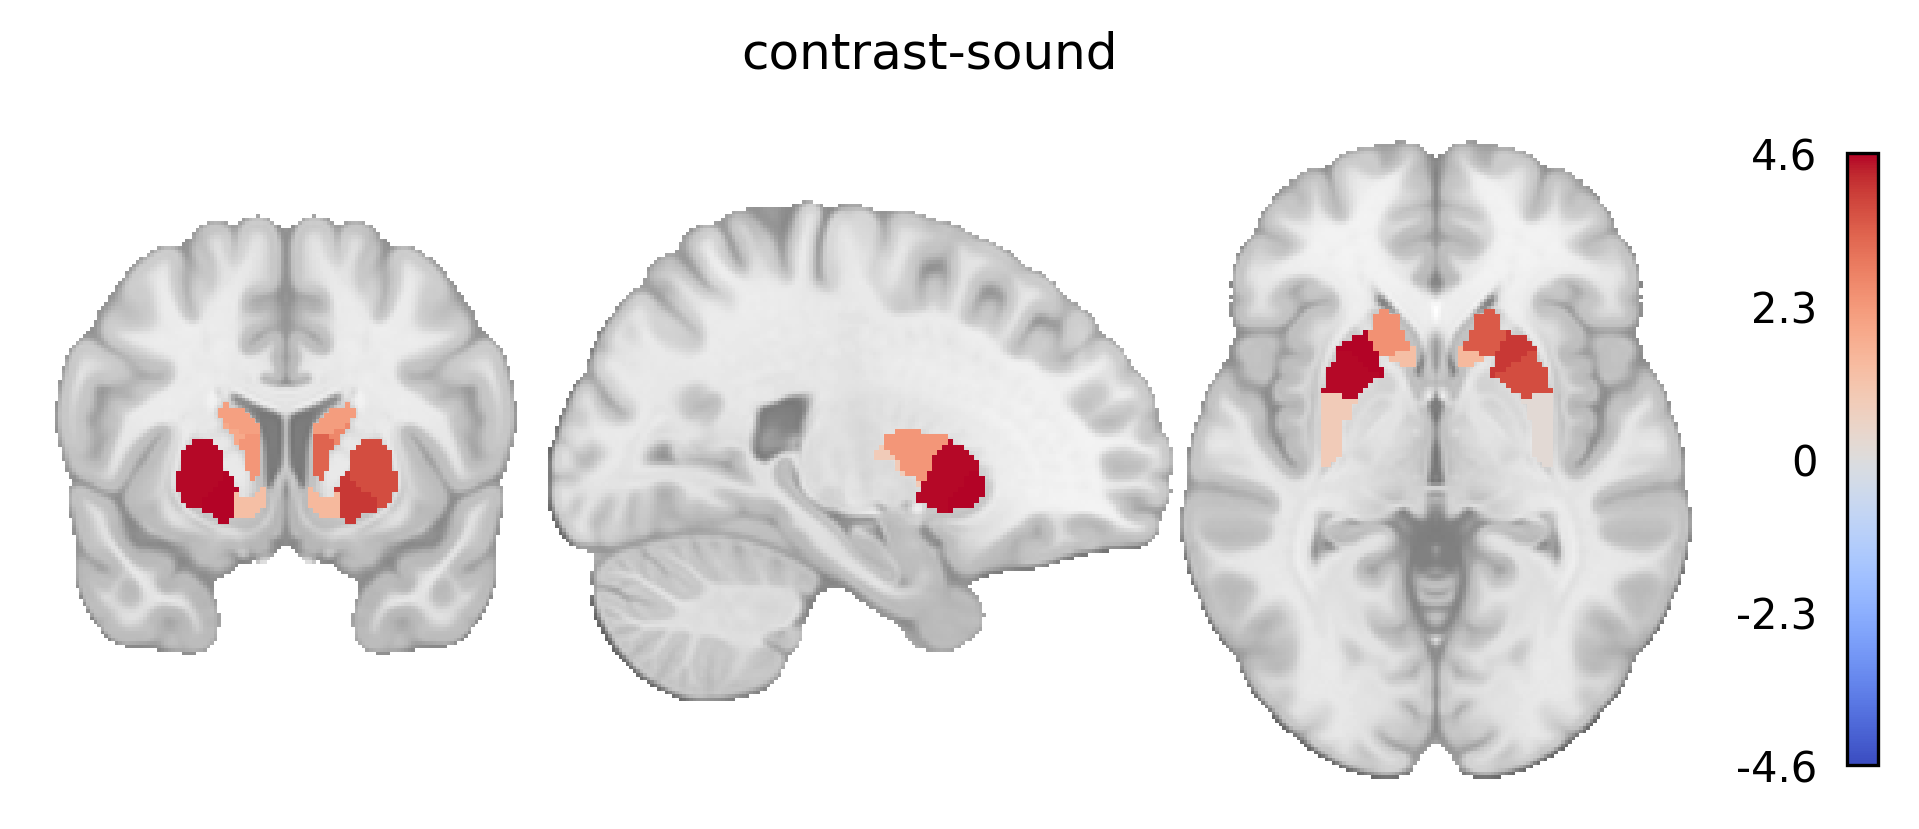

In [35]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5332466/ipykernel_57143/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


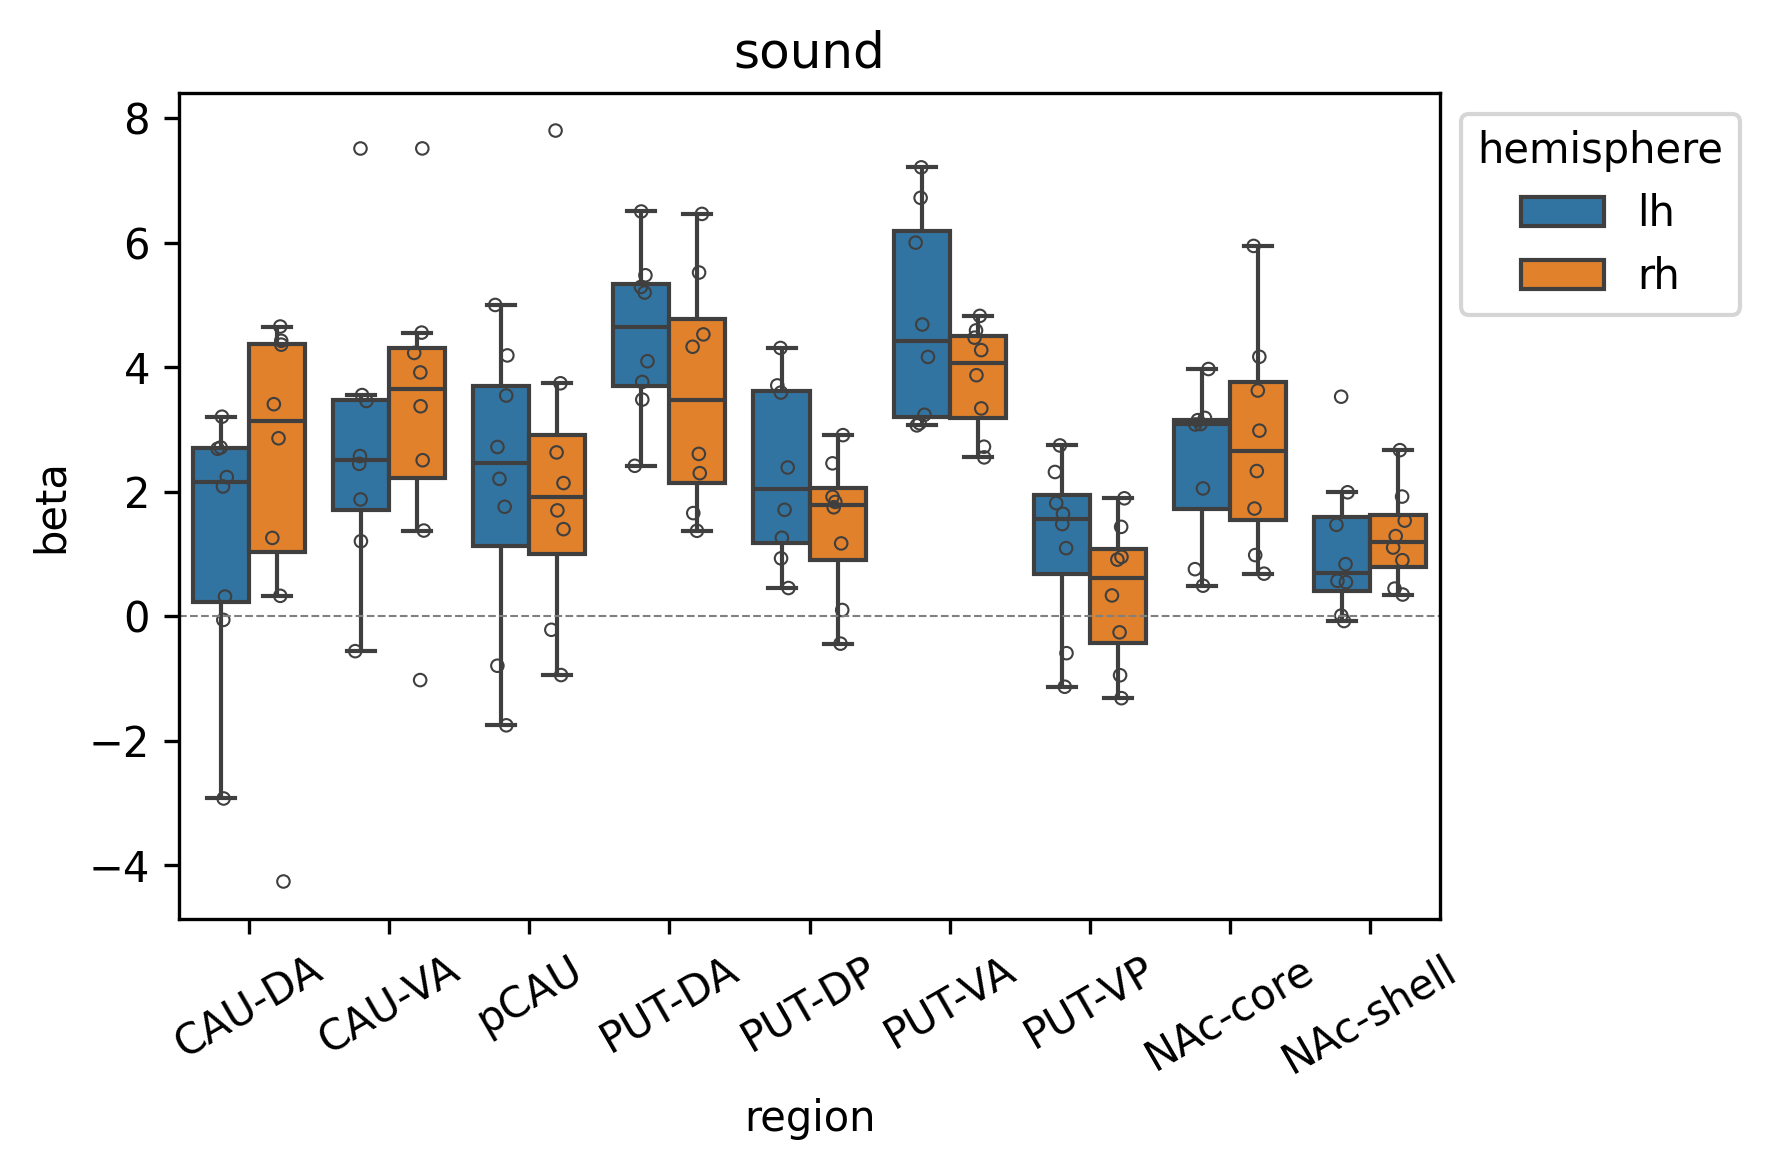

In [22]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [47]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         0.0159 1.0000 11.0000 0.9019
region             6.9006 8.0000 88.0000 0.0000
hemisphere:region  2.9991 8.0000 88.0000 0.0051



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [49]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,CAU-DA,lh,rh,-1.225958,11.0,0.245813,0.316045,0.532
1,region * hemisphere,CAU-VA,lh,rh,-1.547642,11.0,0.149980,0.269965,0.741
2,region * hemisphere,NAc-core,lh,rh,-1.569367,11.0,0.144862,0.269965,0.759
3,region * hemisphere,NAc-shell,lh,rh,-0.728013,11.0,0.481816,0.542043,0.36
4,region * hemisphere,PUT-DA,lh,rh,3.324502,11.0,0.006777,0.030496,8.127
5,region * hemisphere,PUT-DP,lh,rh,3.702735,11.0,0.003485,0.030496,14.064
6,region * hemisphere,PUT-VA,lh,rh,1.326219,11.0,0.211645,0.316045,0.586
7,region * hemisphere,PUT-VP,lh,rh,2.745353,11.0,0.019048,0.057145,3.525
8,region * hemisphere,pCAU,lh,rh,-0.137905,11.0,0.892807,0.892807,0.29


#### Collapse (average) over non-significant factors

In [50]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [51]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=3.691, p=0.0005


In [52]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
   CAU-DA    CAU-VA   0.8647 0.9559 -1.3939  3.1234  False
   CAU-DA  NAc-core   0.3929 0.9998 -1.8658  2.6516  False
   CAU-DA NAc-shell  -0.4725 0.9992 -2.7312  1.7862  False
   CAU-DA    PUT-DA   1.8944 0.1812 -0.3642  4.1531  False
   CAU-DA    PUT-DP   0.1634    1.0 -2.0953   2.422  False
   CAU-DA    PUT-VA   1.8554 0.2038 -0.4033   4.114  False
   CAU-DA    PUT-VP  -0.9047 0.9428 -3.1634  1.3539  False
   CAU-DA      pCAU  -0.2518    1.0 -2.5105  2.0068  False
   CAU-VA  NAc-core  -0.4718 0.9992 -2.7305  1.7868  False
   CAU-VA NAc-shell  -1.3372 0.6452 -3.5959  0.9215  False
   CAU-VA    PUT-DA   1.0297 0.8857  -1.229  3.2884  False
   CAU-VA    PUT-DP  -0.7014 0.9879   -2.96  1.5573  False
   CAU-VA    PUT-VA   0.9906 0.9063  -1.268  3.2493  False
   CAU-VA    PUT-VP  -1.7695 0.2603 -4.0281  0.4892  Fal

In [53]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('CAU-DA',), t-stat: 3.09 -> Corrected p=0.0064
Region: ('CAU-VA',), t-stat: 3.18 -> Corrected p=0.0061
Region: ('NAc-core',), t-stat: 4.28 -> Corrected p=0.0005
Region: ('NAc-shell',), t-stat: 4.23 -> Corrected p=0.0005
Region: ('PUT-DA',), t-stat: 9.01 -> Corrected p=0.0000
Region: ('PUT-DP',), t-stat: 6.37 -> Corrected p=0.0000
Region: ('PUT-VA',), t-stat: 8.55 -> Corrected p=0.0000
Region: ('PUT-VP',), t-stat: 2.23 -> Corrected p=0.0351
Region: ('pCAU',), t-stat: 2.33 -> Corrected p=0.0321


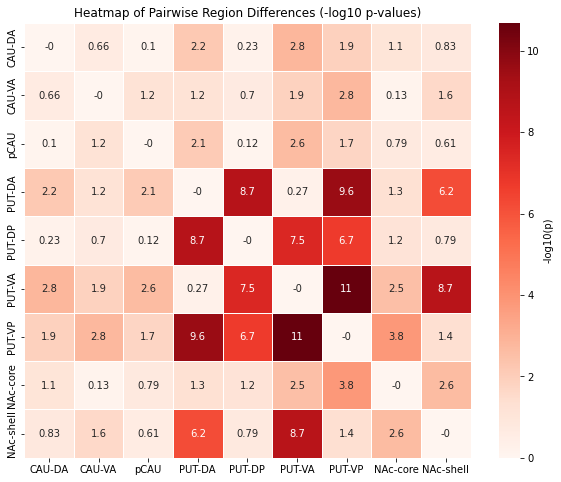

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


### Make 3D plots

In [57]:
region_list = region_dict[network_name]

In [55]:
mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [58]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_surface.svg')

IndexError: list index out of range

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

## `contrast-sound` for cortical network

In [36]:
network_name = network_list[0]
contrast_label = contrast_list[0]

statmap_dict = {}
for sub_id in subjects_label:
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [37]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

masking sound stat maps for the auditory network
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [38]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_df, network_name)

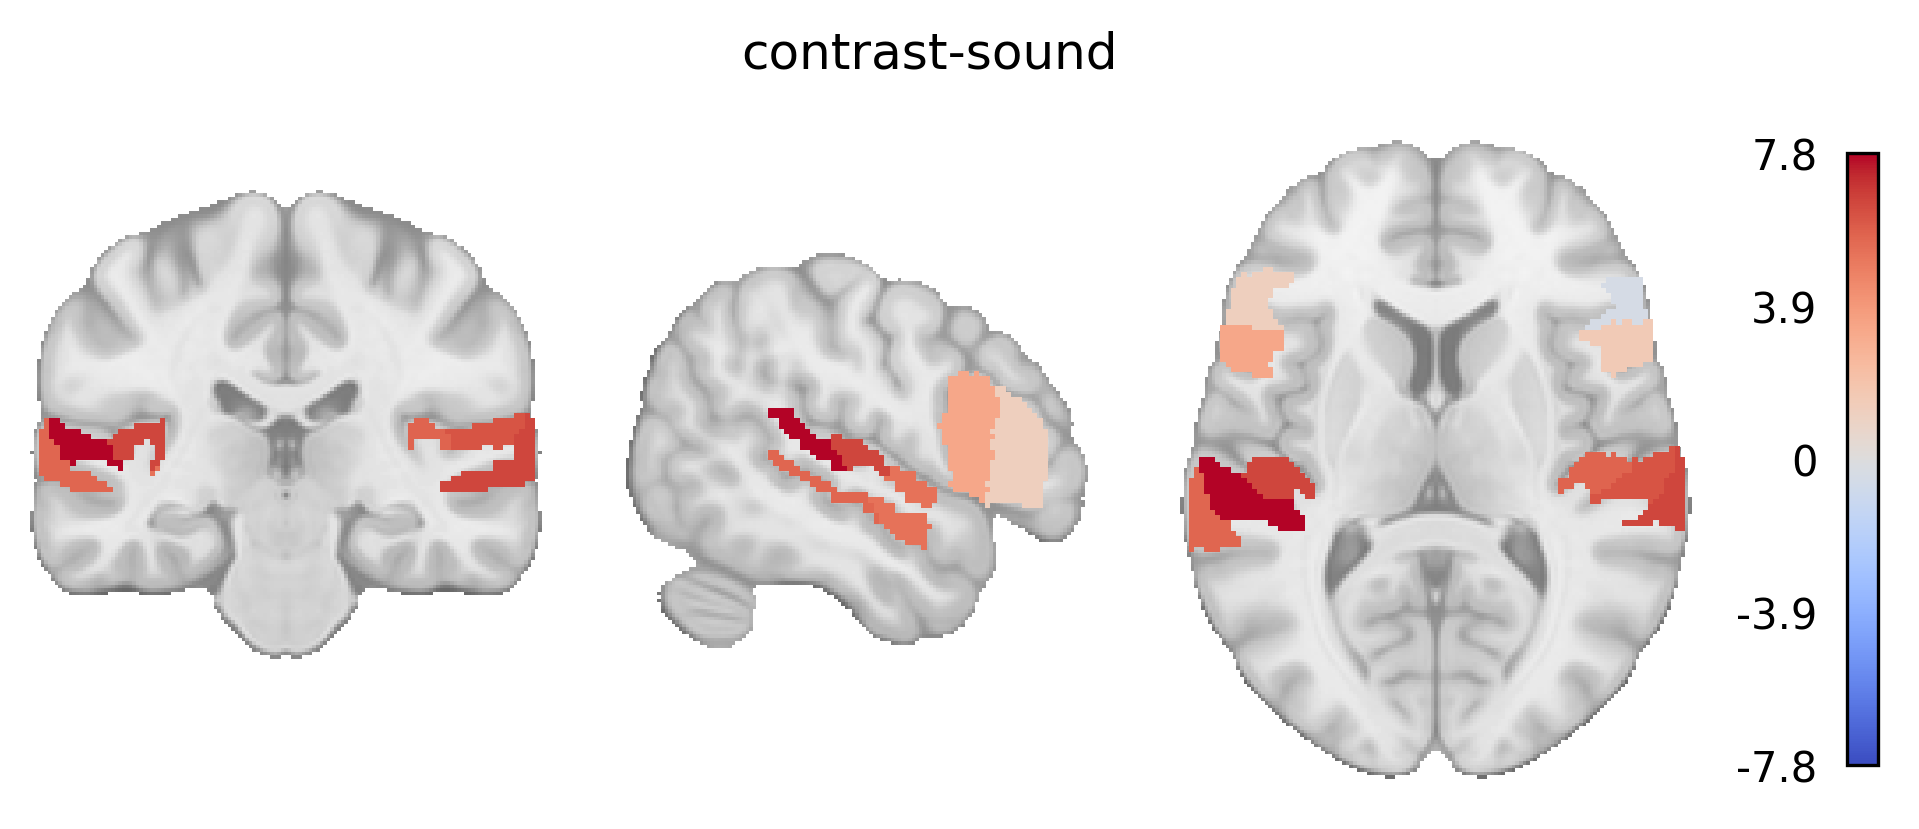

In [40]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5332466/ipykernel_57143/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


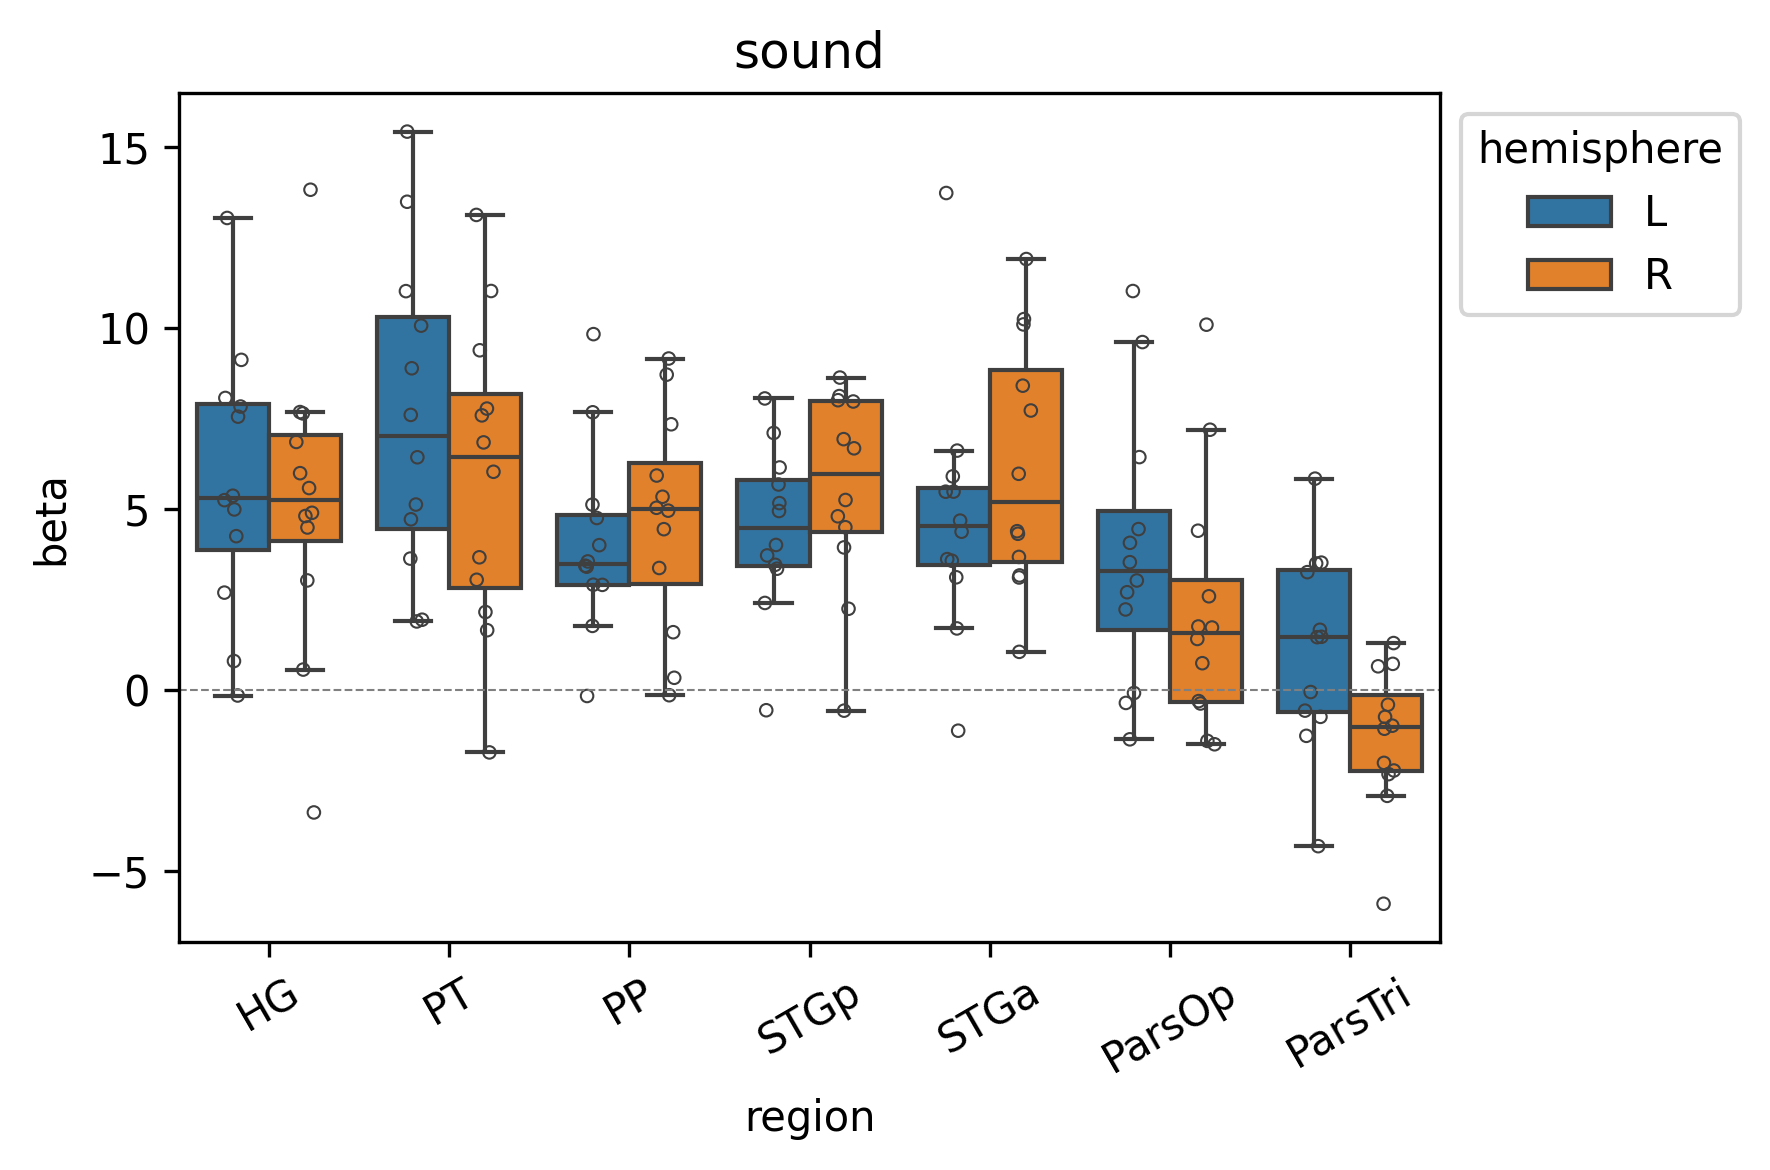

In [39]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [98]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         2.2197 1.0000 11.0000 0.1644
region            15.4179 6.0000 66.0000 0.0000
hemisphere:region  5.3570 6.0000 66.0000 0.0001



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [100]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,HG,L,R,0.828055,11.0,0.425240,0.425240,0.384
1,region * hemisphere,PP,L,R,-1.081036,11.0,0.302812,0.353280,0.467
2,region * hemisphere,PT,L,R,2.793732,11.0,0.017470,0.061143,3.776
3,region * hemisphere,ParsOp,L,R,1.721047,11.0,0.113209,0.158492,0.904
4,region * hemisphere,ParsTri,L,R,3.546703,11.0,0.004578,0.032049,11.22
5,region * hemisphere,STGa,L,R,-1.925840,11.0,0.080352,0.140616,1.16
6,region * hemisphere,STGp,L,R,-2.201644,11.0,0.049943,0.116533,1.66


#### Collapse (average) over non-significant factors

In [101]:
roi_df_collapsed = non_mandarin_df.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [102]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=5.998, p=0.0000


In [103]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
     HG      PP  -1.0629 0.9817  -4.9682  2.8425  False
     HG      PT   1.2508  0.959  -2.6546  5.1561  False
     HG  ParsOp  -2.4661 0.4789  -6.3715  1.4392  False
     HG ParsTri  -5.5392  0.001  -9.4445 -1.6338   True
     HG    STGa   0.0181    1.0  -3.8872  3.9234  False
     HG    STGp  -0.4501 0.9998  -4.3554  3.4553  False
     PP      PT   2.3136 0.5563  -1.5917   6.219  False
     PP  ParsOp  -1.4033 0.9299  -5.3086  2.5021  False
     PP ParsTri  -4.4763 0.0144  -8.3817  -0.571   True
     PP    STGa    1.081 0.9801  -2.8244  4.9863  False
     PP    STGp   0.6128 0.9991  -3.2925  4.5181  False
     PT  ParsOp  -3.7169 0.0726  -7.6222  0.1885  False
     PT ParsTri  -6.7899    0.0 -10.6953 -2.8846   True
     PT    STGa  -1.2327 0.9618   -5.138  2.6727  False
     PT    STGp  -1.7008 0.8412  -5.6062  2.2045

In [104]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('HG',), t-stat: 5.04 -> Corrected p=0.0005
Region: ('PP',), t-stat: 5.73 -> Corrected p=0.0003
Region: ('PT',), t-stat: 5.52 -> Corrected p=0.0003
Region: ('ParsOp',), t-stat: 3.16 -> Corrected p=0.0106
Region: ('ParsTri',), t-stat: -0.14 -> Corrected p=0.8888
Region: ('STGa',), t-stat: 5.86 -> Corrected p=0.0003
Region: ('STGp',), t-stat: 7.27 -> Corrected p=0.0001


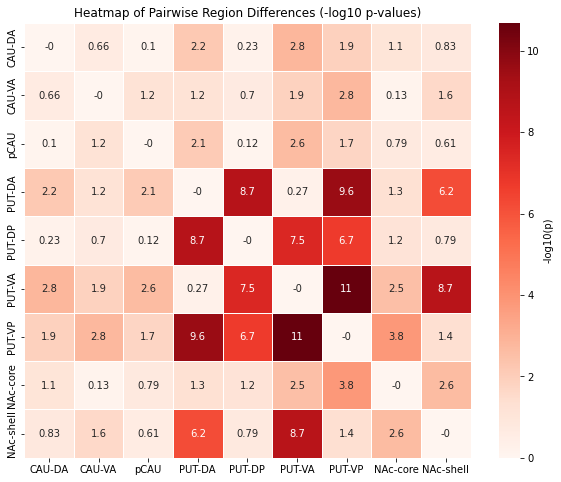

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


### Make 3D plots

In [106]:
region_list = region_dict[network_name]

In [107]:
mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [108]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_surface.svg')

IndexError: list index out of range

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

## `contrast-resp` for striatal network

In [41]:
network_name = network_list[1]
contrast_label = contrast_list[1]

statmap_dict = {}
for sub_id in sub_list_nman: # use 'nman' for fb contrasts
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [42]:
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [43]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_nman_df, network_name)

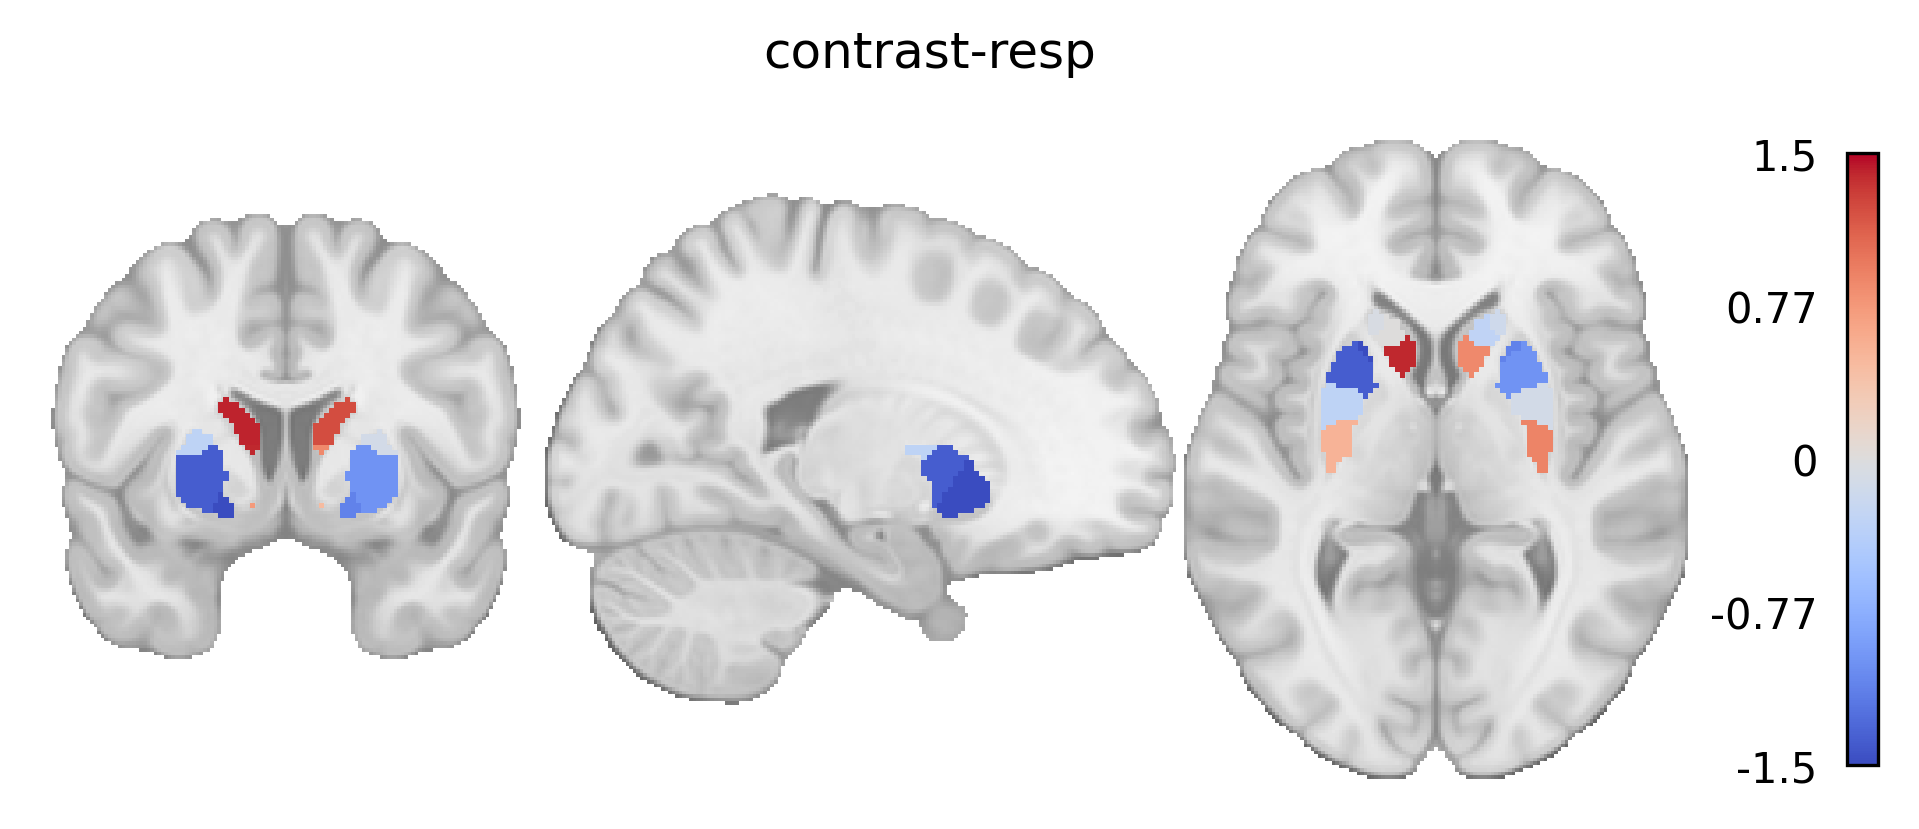

In [44]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5327152/ipykernel_22559/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


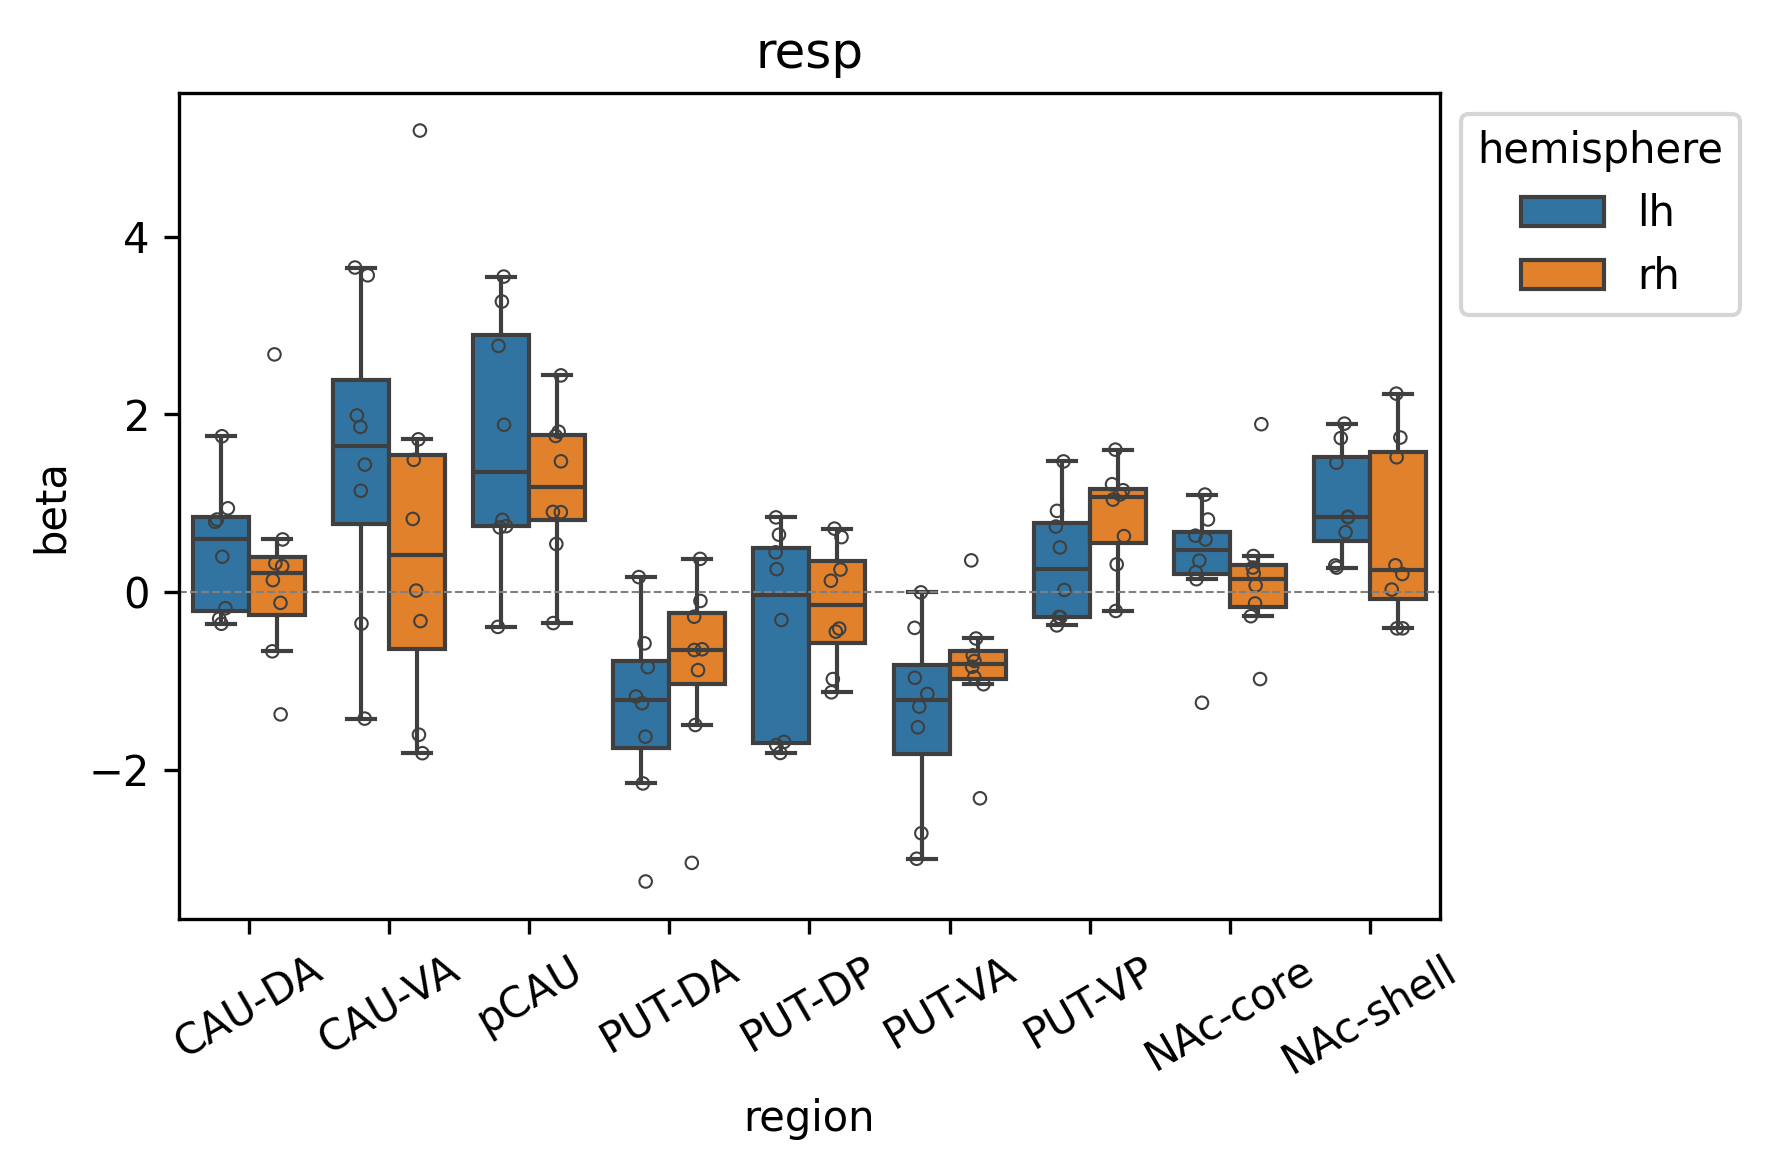

In [117]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [118]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         0.0324 1.0000  7.0000 0.8622
region             8.8878 8.0000 56.0000 0.0000
hemisphere:region  1.6459 8.0000 56.0000 0.1327



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [120]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,CAU-DA,lh,rh,0.597388,7.0,0.569061,0.640193,0.39
1,region * hemisphere,CAU-VA,lh,rh,1.207972,7.0,0.266281,0.399421,0.59
2,region * hemisphere,NAc-core,lh,rh,0.348082,7.0,0.738012,0.738012,0.354
3,region * hemisphere,NAc-shell,lh,rh,1.600903,7.0,0.153432,0.345222,0.847
4,region * hemisphere,PUT-DA,lh,rh,-6.154162,7.0,0.000466,0.004191,76.948
5,region * hemisphere,PUT-DP,lh,rh,-1.265914,7.0,0.246045,0.399421,0.62
6,region * hemisphere,PUT-VA,lh,rh,-2.057165,7.0,0.078694,0.236081,1.359
7,region * hemisphere,PUT-VP,lh,rh,-2.742305,7.0,0.028822,0.129700,2.877
8,region * hemisphere,pCAU,lh,rh,0.801113,7.0,0.449399,0.577799,0.437


#### Collapse (average) over non-significant factors

In [121]:
roi_df_collapsed = non_mandarin_df.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [122]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=7.147, p=0.0000


In [123]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
   CAU-DA    CAU-VA   0.7281 0.8386 -0.8035  2.2598  False
   CAU-DA  NAc-core  -0.1013    1.0 -1.6329  1.4304  False
   CAU-DA NAc-shell   0.4699 0.9859 -1.0618  2.0016  False
   CAU-DA    PUT-DA  -1.4482  0.078 -2.9798  0.0835  False
   CAU-DA    PUT-DP  -0.6445 0.9112 -2.1762  0.8871  False
   CAU-DA    PUT-VA   -1.474 0.0682 -3.0057  0.0576  False
   CAU-DA    PUT-VP   0.2393 0.9999 -1.2924   1.771  False
   CAU-DA      pCAU   1.0706 0.3906 -0.4611  2.6023  False
   CAU-VA  NAc-core  -0.8294 0.7203 -2.3611  0.7023  False
   CAU-VA NAc-shell  -0.2583 0.9998 -1.7899  1.2734  False
   CAU-VA    PUT-DA  -2.1763 0.0008  -3.708 -0.6446   True
   CAU-VA    PUT-DP  -1.3727 0.1138 -2.9043   0.159  False
   CAU-VA    PUT-VA  -2.2022 0.0006 -3.7338 -0.6705   True
   CAU-VA    PUT-VP  -0.4889 0.9819 -2.0205  1.0428  Fal

In [124]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('CAU-DA',), t-stat: 1.30 -> Corrected p=0.2649
Region: ('CAU-VA',), t-stat: 1.73 -> Corrected p=0.1921
Region: ('NAc-core',), t-stat: 1.45 -> Corrected p=0.2431
Region: ('NAc-shell',), t-stat: 2.96 -> Corrected p=0.0382
Region: ('PUT-DA',), t-stat: -2.97 -> Corrected p=0.0382
Region: ('PUT-DP',), t-stat: -0.90 -> Corrected p=0.3976
Region: ('PUT-VA',), t-stat: -3.84 -> Corrected p=0.0287
Region: ('PUT-VP',), t-stat: 2.96 -> Corrected p=0.0382
Region: ('pCAU',), t-stat: 5.03 -> Corrected p=0.0136


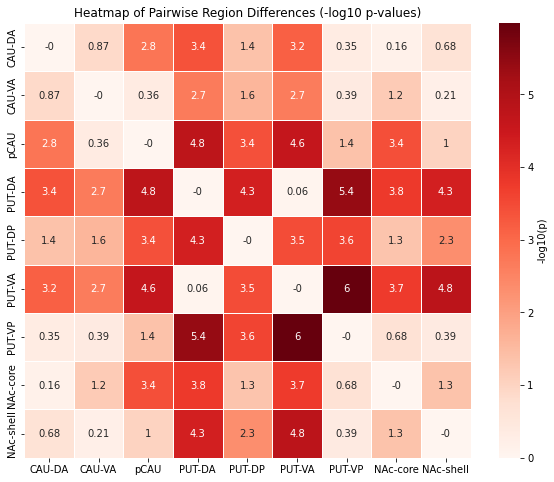

In [125]:
from itertools import combinations
from scipy.stats import ttest_rel

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


### Make 3D plots

In [57]:
region_list = region_dict[network_name]

In [55]:
mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [58]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_surface.svg')

IndexError: list index out of range

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

## `contrast-resp` for cortical network

In [45]:
network_name = network_list[0]
contrast_label = contrast_list[2]

statmap_dict = {}
for sub_id in sub_list_nman:
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [46]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

masking fb-correct-vs-wrong stat maps for the auditory network
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [47]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_nman_df, network_name)

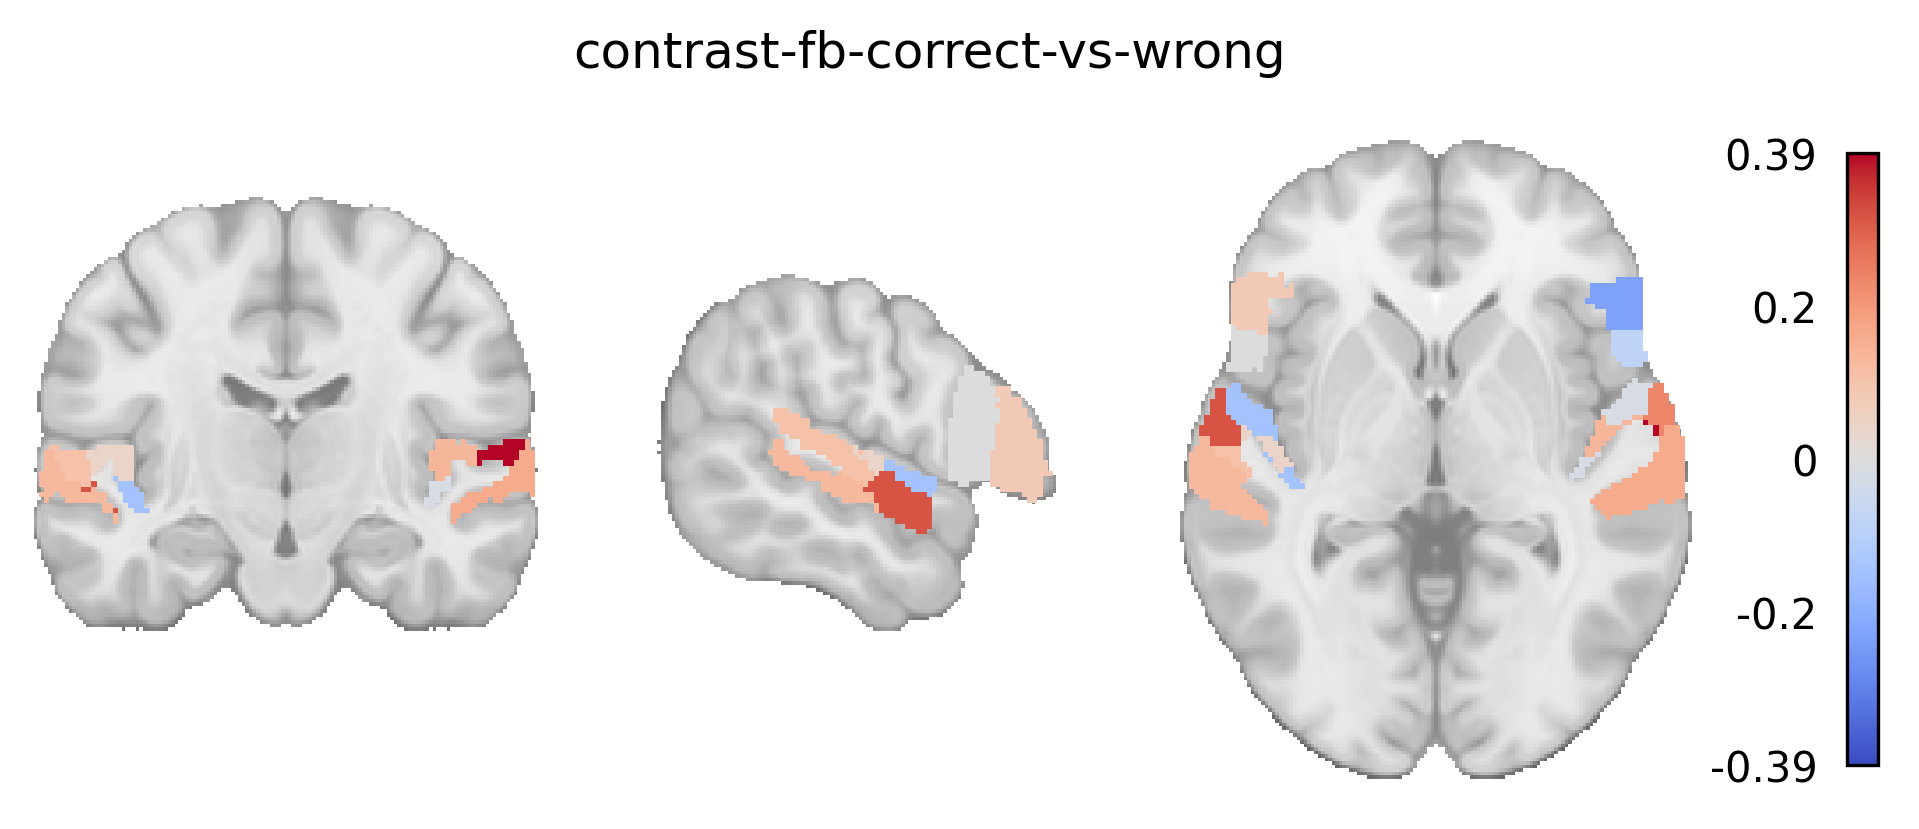

In [48]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5327152/ipykernel_22559/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


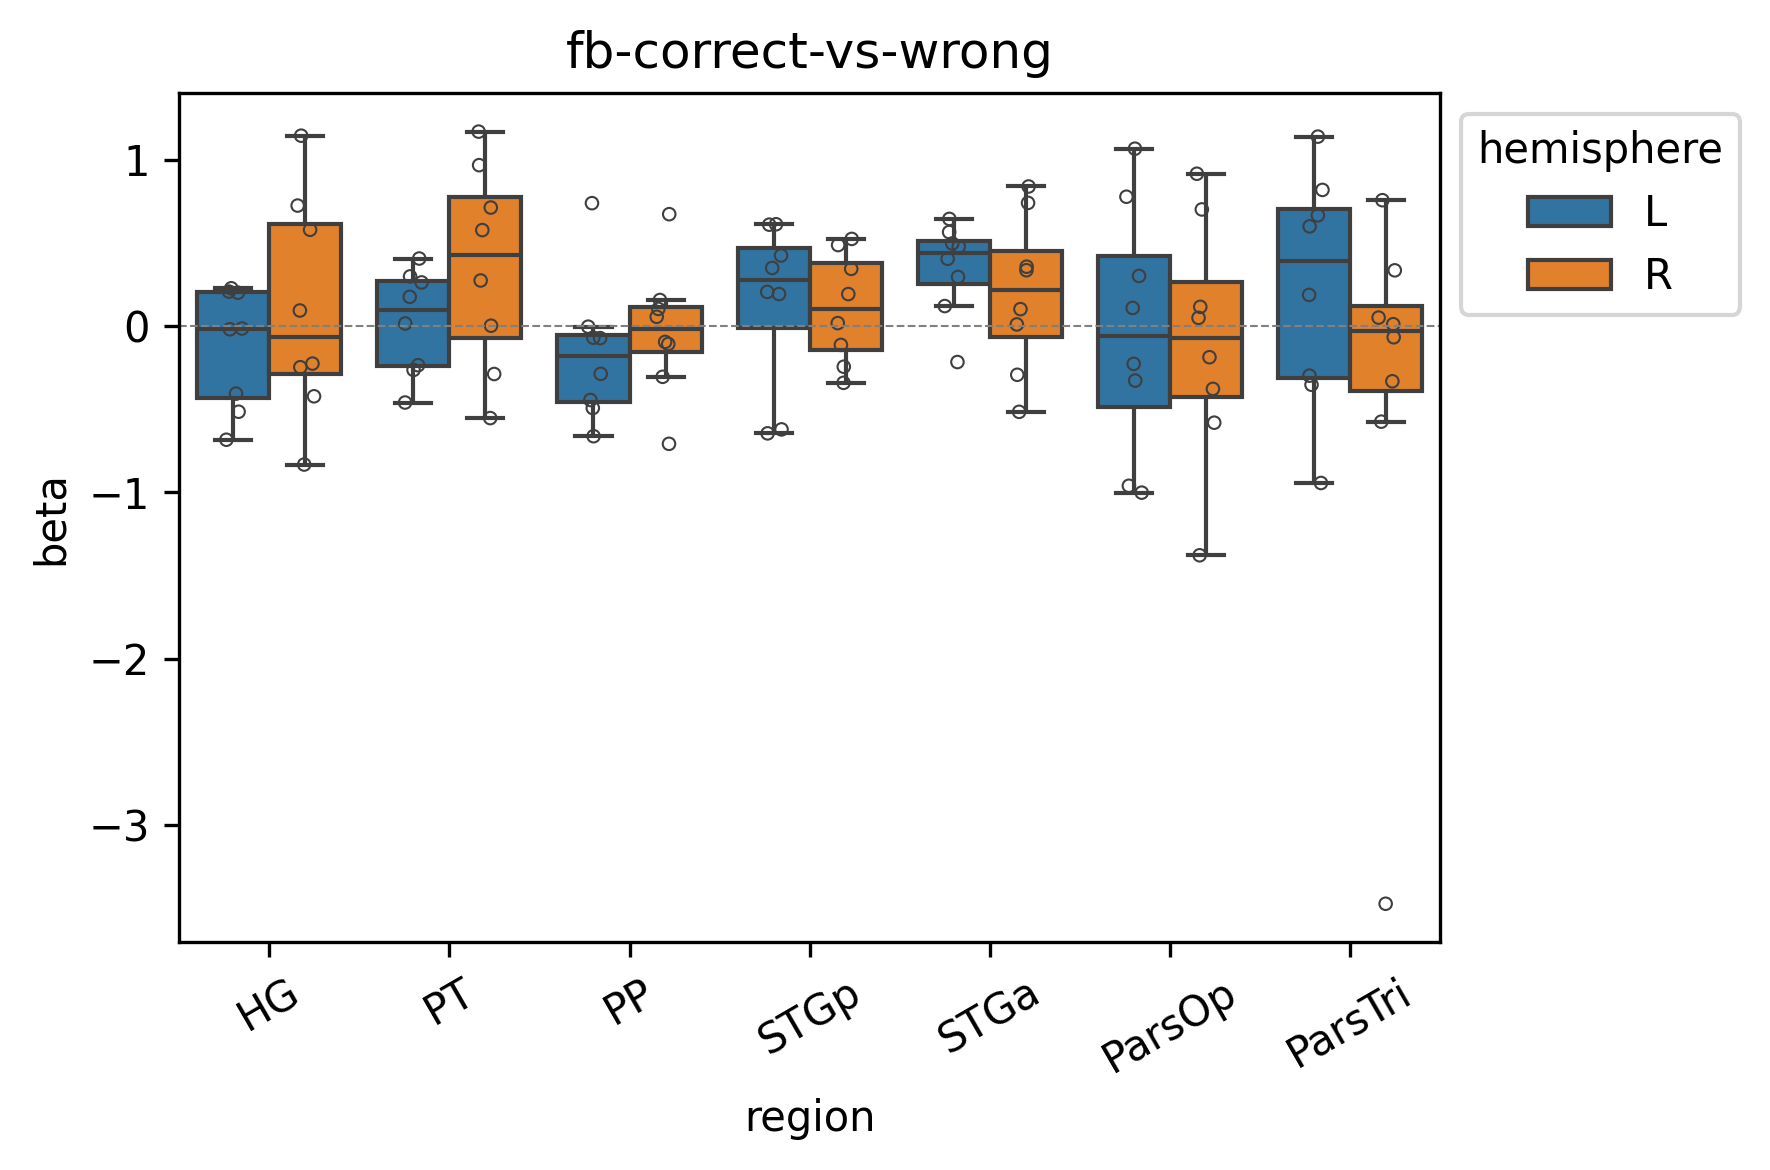

In [129]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [130]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         0.0932 1.0000  7.0000 0.7690
region             1.0386 6.0000 42.0000 0.4143
hemisphere:region  2.0469 6.0000 42.0000 0.0804



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [132]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,HG,L,R,-1.042210,7.0,0.331966,0.581204,0.516
1,region * hemisphere,PP,L,R,-0.775757,7.0,0.463291,0.648607,0.43
2,region * hemisphere,PT,L,R,-1.516453,7.0,0.173188,0.581204,0.781
3,region * hemisphere,ParsOp,L,R,0.227014,7.0,0.826901,0.884964,0.344
4,region * hemisphere,ParsTri,L,R,2.129699,7.0,0.070702,0.494911,1.47
5,region * hemisphere,STGa,L,R,1.041862,7.0,0.332116,0.581204,0.516
6,region * hemisphere,STGp,L,R,0.150042,7.0,0.884964,0.884964,0.339


#### Collapse (average) over non-significant factors

In [133]:
roi_df_collapsed = non_mandarin_df.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [134]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=0.635, p=0.7017


In [135]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
     HG      PP  -0.0832 0.9999 -0.8949 0.7285  False
     HG      PT    0.203 0.9869 -0.6086 1.0147  False
     HG  ParsOp  -0.0509    1.0 -0.8626 0.7608  False
     HG ParsTri  -0.0805 0.9999 -0.8922 0.7312  False
     HG    STGa   0.2845 0.9318 -0.5272 1.0961  False
     HG    STGp   0.1364 0.9985 -0.6753 0.9481  False
     PP      PT   0.2863 0.9298 -0.5254  1.098  False
     PP  ParsOp   0.0324    1.0 -0.7793 0.8441  False
     PP ParsTri   0.0028    1.0 -0.8089 0.8145  False
     PP    STGa   0.3677 0.8031  -0.444 1.1794  False
     PP    STGp   0.2196 0.9804 -0.5921 1.0313  False
     PT  ParsOp  -0.2539 0.9598 -1.0656 0.5578  False
     PT ParsTri  -0.2835 0.9328 -1.0952 0.5282  False
     PT    STGa   0.0814 0.9999 -0.7303 0.8931  False
     PT    STGp  -0.0667    1.0 -0.8784  0.745  False
 ParsOp ParsTri  -0.0296    

In [136]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('HG',), t-stat: -0.08 -> Corrected p=0.9363
Region: ('PP',), t-stat: -0.81 -> Corrected p=0.7799
Region: ('PT',), t-stat: 1.45 -> Corrected p=0.6360
Region: ('ParsOp',), t-stat: -0.28 -> Corrected p=0.9226
Region: ('ParsTri',), t-stat: -0.28 -> Corrected p=0.9226
Region: ('STGa',), t-stat: 2.35 -> Corrected p=0.3593
Region: ('STGp',), t-stat: 1.19 -> Corrected p=0.6360


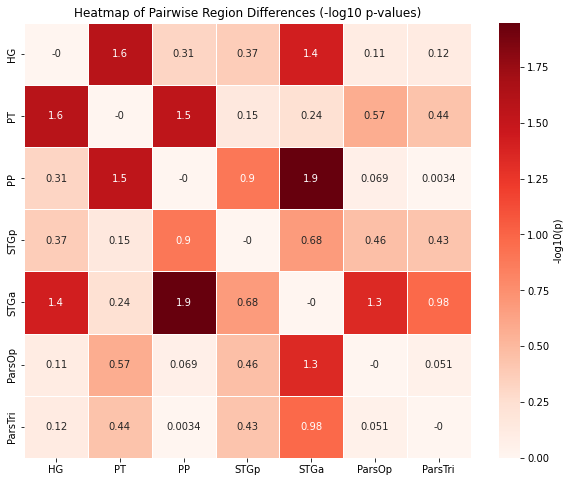

In [137]:
from itertools import combinations
from scipy.stats import ttest_rel

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-fb` for striatal network

In [49]:
network_name = network_list[1]
contrast_label = contrast_list[2]

statmap_dict = {}
for sub_id in sub_list_nman: # use 'nman' for fb contrasts
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [50]:
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [51]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_nman_df, network_name)

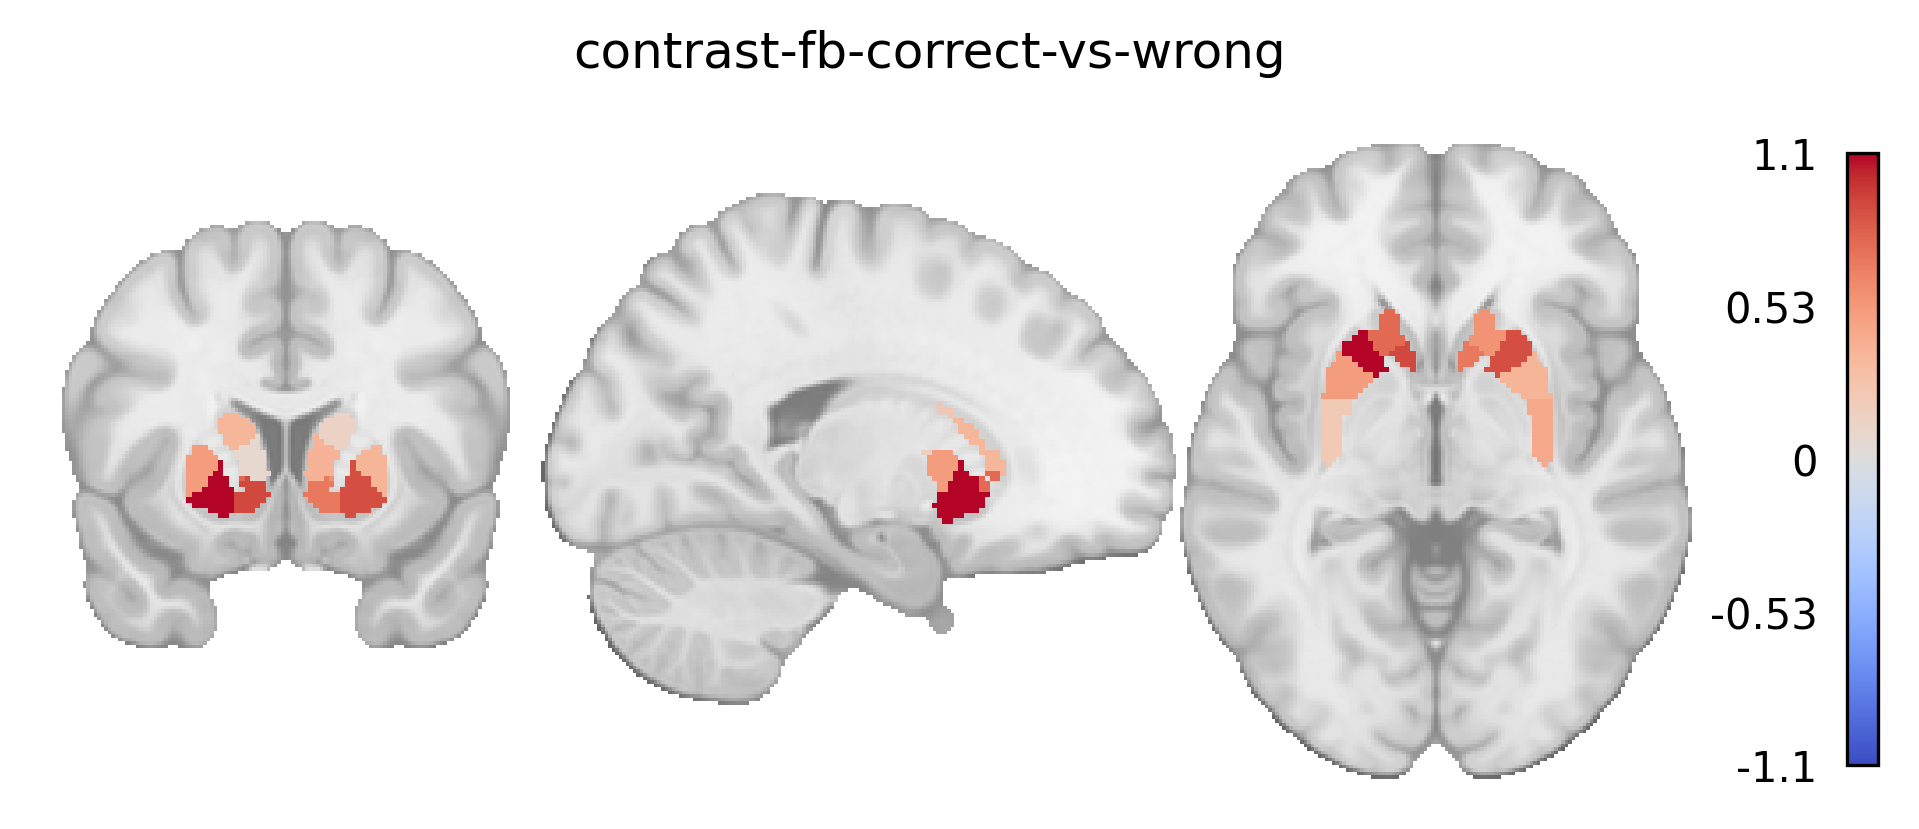

In [52]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5327152/ipykernel_22559/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


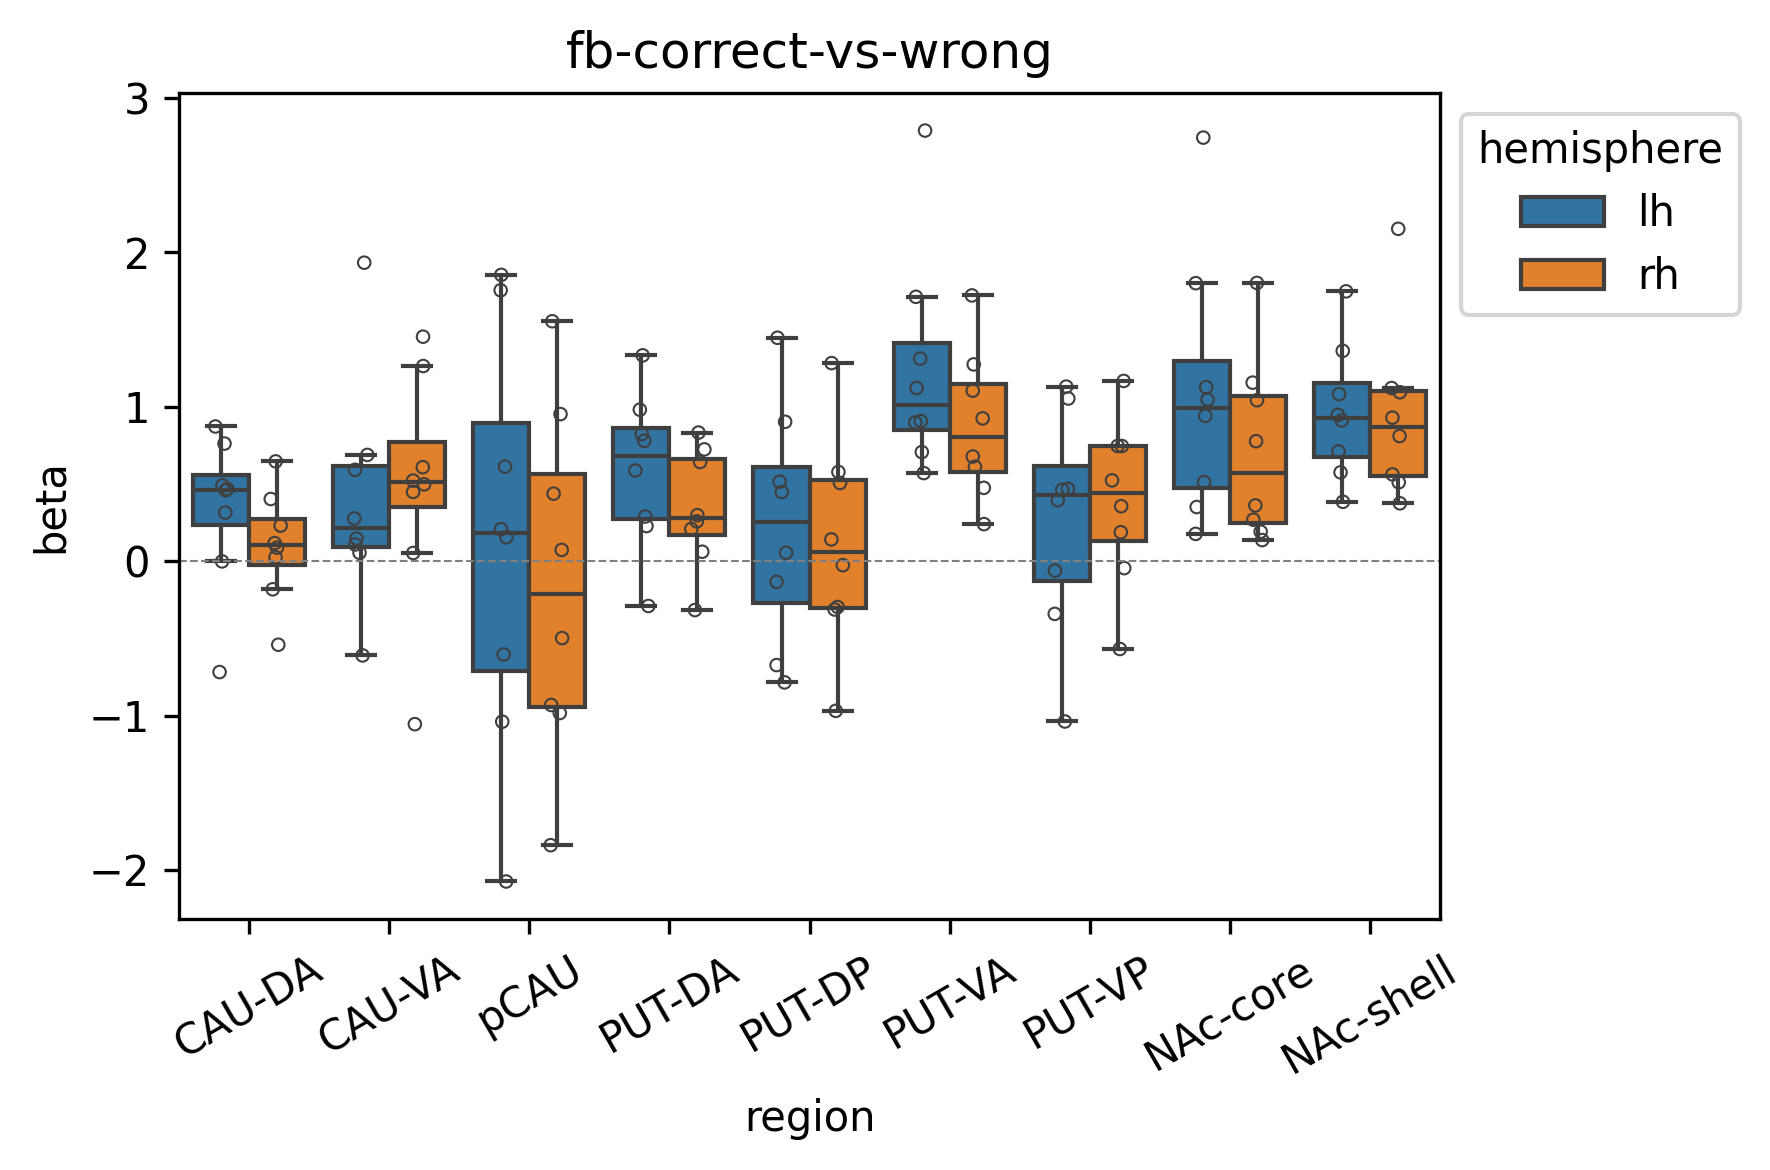

In [45]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         4.6242 1.0000  7.0000 0.0686
region             3.3964 8.0000 56.0000 0.0030
hemisphere:region  0.9470 8.0000 56.0000 0.4862



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [48]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,CAU-DA,lh,rh,2.016913,7.0,0.083510,0.375794,1.302
1,region * hemisphere,CAU-VA,lh,rh,-0.337325,7.0,0.745761,0.838981,0.353
2,region * hemisphere,NAc-core,lh,rh,1.602181,7.0,0.153150,0.435160,0.849
3,region * hemisphere,NAc-shell,lh,rh,0.124435,7.0,0.904469,0.904469,0.338
4,region * hemisphere,PUT-DA,lh,rh,3.104044,7.0,0.017224,0.155019,4.274
5,region * hemisphere,PUT-DP,lh,rh,0.867473,7.0,0.414429,0.621643,0.456
6,region * hemisphere,PUT-VA,lh,rh,1.278717,7.0,0.241756,0.435160,0.627
7,region * hemisphere,PUT-VP,lh,rh,-0.586608,7.0,0.575887,0.740427,0.388
8,region * hemisphere,pCAU,lh,rh,1.354249,7.0,0.217744,0.435160,0.671


#### Collapse (average) over non-significant factors

In [50]:
roi_df_collapsed = non_mandarin_df.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [51]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=2.757, p=0.0112


In [52]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
   CAU-DA    CAU-VA   0.2217 0.9989 -0.8333  1.2767  False
   CAU-DA  NAc-core   0.6874 0.4874 -0.3676  1.7424  False
   CAU-DA NAc-shell   0.7401 0.3855 -0.3149  1.7951  False
   CAU-DA    PUT-DA   0.2504 0.9975 -0.8046  1.3054  False
   CAU-DA    PUT-DP   -0.047    1.0  -1.102   1.008  False
   CAU-DA    PUT-VA   0.8507 0.2117 -0.2043  1.9057  False
   CAU-DA    PUT-VP   0.1093    1.0 -0.9457  1.1643  False
   CAU-DA      pCAU  -0.2376 0.9983 -1.2926  0.8174  False
   CAU-VA  NAc-core   0.4657 0.8868 -0.5893  1.5207  False
   CAU-VA NAc-shell   0.5184 0.8127 -0.5366  1.5734  False
   CAU-VA    PUT-DA   0.0286    1.0 -1.0264  1.0836  False
   CAU-VA    PUT-DP  -0.2688 0.9959 -1.3238  0.7862  False
   CAU-VA    PUT-VA   0.6289 0.6064 -0.4261  1.6839  False
   CAU-VA    PUT-VP  -0.1124    1.0 -1.1674  0.9426  Fal

In [53]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('CAU-DA',), t-stat: 1.50 -> Corrected p=0.2286
Region: ('CAU-VA',), t-stat: 1.81 -> Corrected p=0.2042
Region: ('NAc-core',), t-stat: 3.93 -> Corrected p=0.0171
Region: ('NAc-shell',), t-stat: 6.09 -> Corrected p=0.0022
Region: ('PUT-DA',), t-stat: 3.03 -> Corrected p=0.0428
Region: ('PUT-DP',), t-stat: 0.67 -> Corrected p=0.5888
Region: ('PUT-VA',), t-stat: 6.72 -> Corrected p=0.0022
Region: ('PUT-VP',), t-stat: 1.65 -> Corrected p=0.2135
Region: ('pCAU',), t-stat: -0.06 -> Corrected p=0.9570


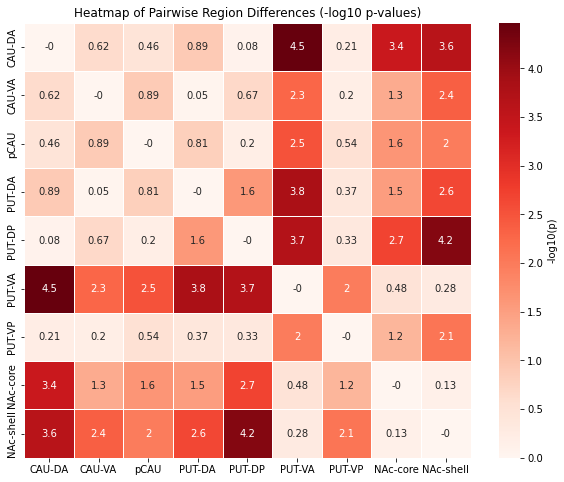

In [55]:
from itertools import combinations
from scipy.stats import ttest_rel

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


### Make 3D plots

In [57]:
region_list = region_dict[network_name]

In [55]:
mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [58]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_surface.svg')

IndexError: list index out of range

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

## `contrast-fb` for cortical network

In [53]:
network_name = network_list[0]
contrast_label = contrast_list[2]

statmap_dict = {}
for sub_id in sub_list_nman:
    statmap_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all/*{contrast_label}_map-beta.nii.gz'))[0]

In [54]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_dict, 
                                               masks_dir, 
                                               space_label)

masking fb-correct-vs-wrong stat maps for the auditory network
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [55]:
non_mandarin_df = make_stats_df(roi_mean_dict, participants_nman_df, network_name)

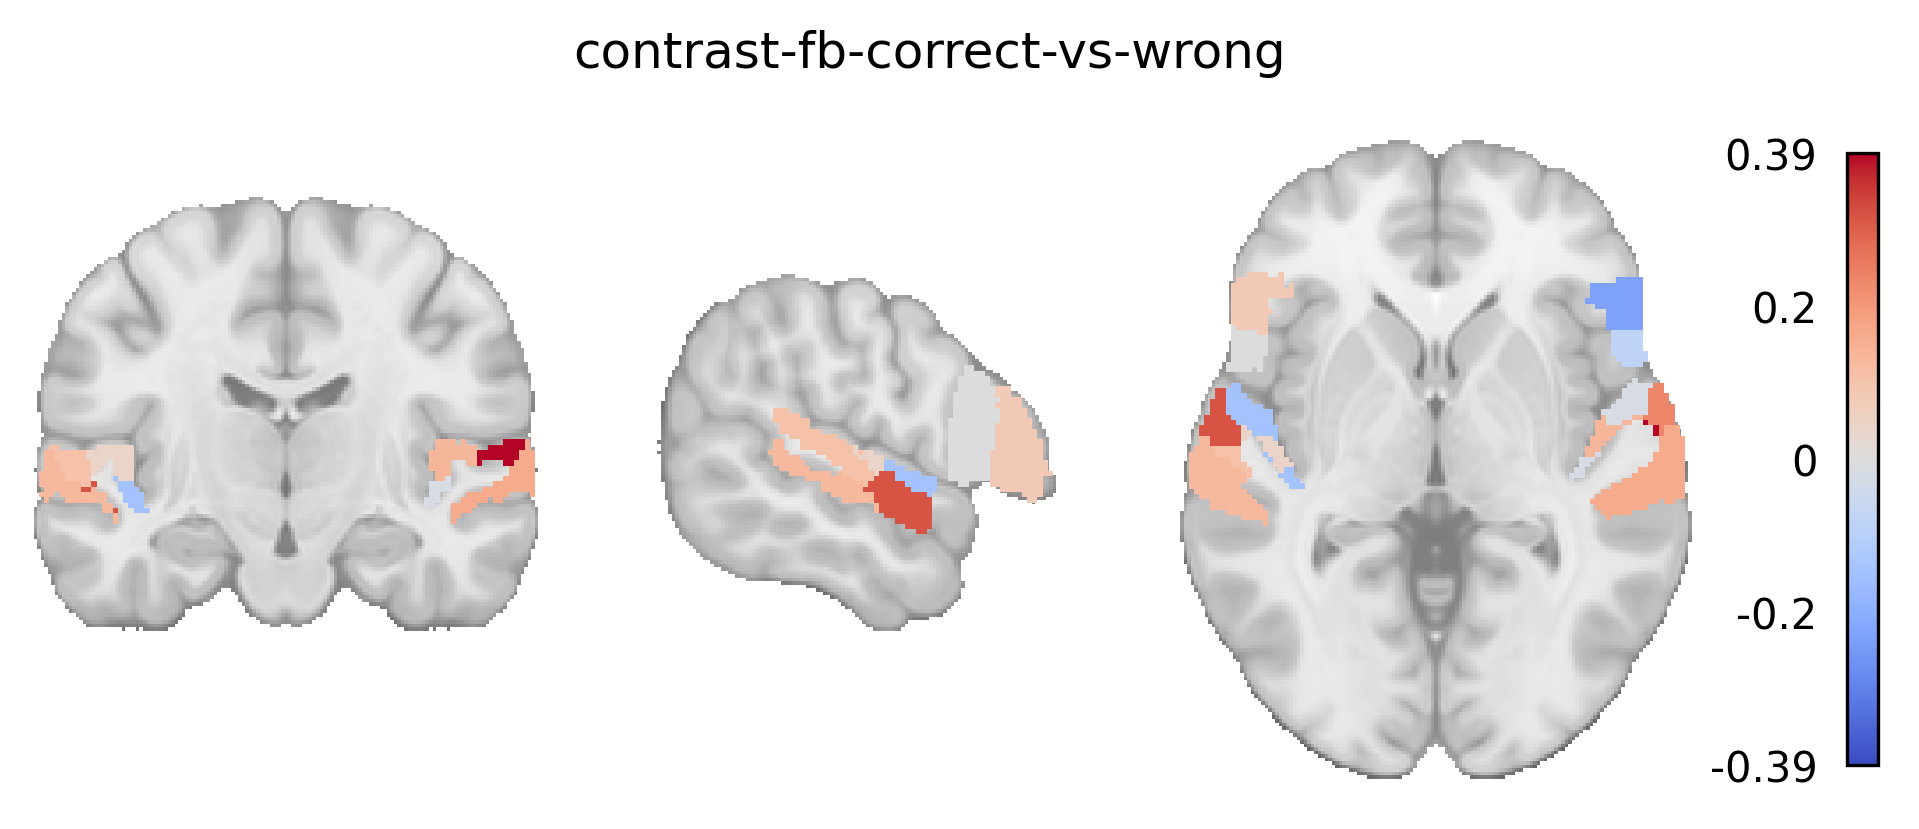

In [56]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5327152/ipykernel_22559/2360889153.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


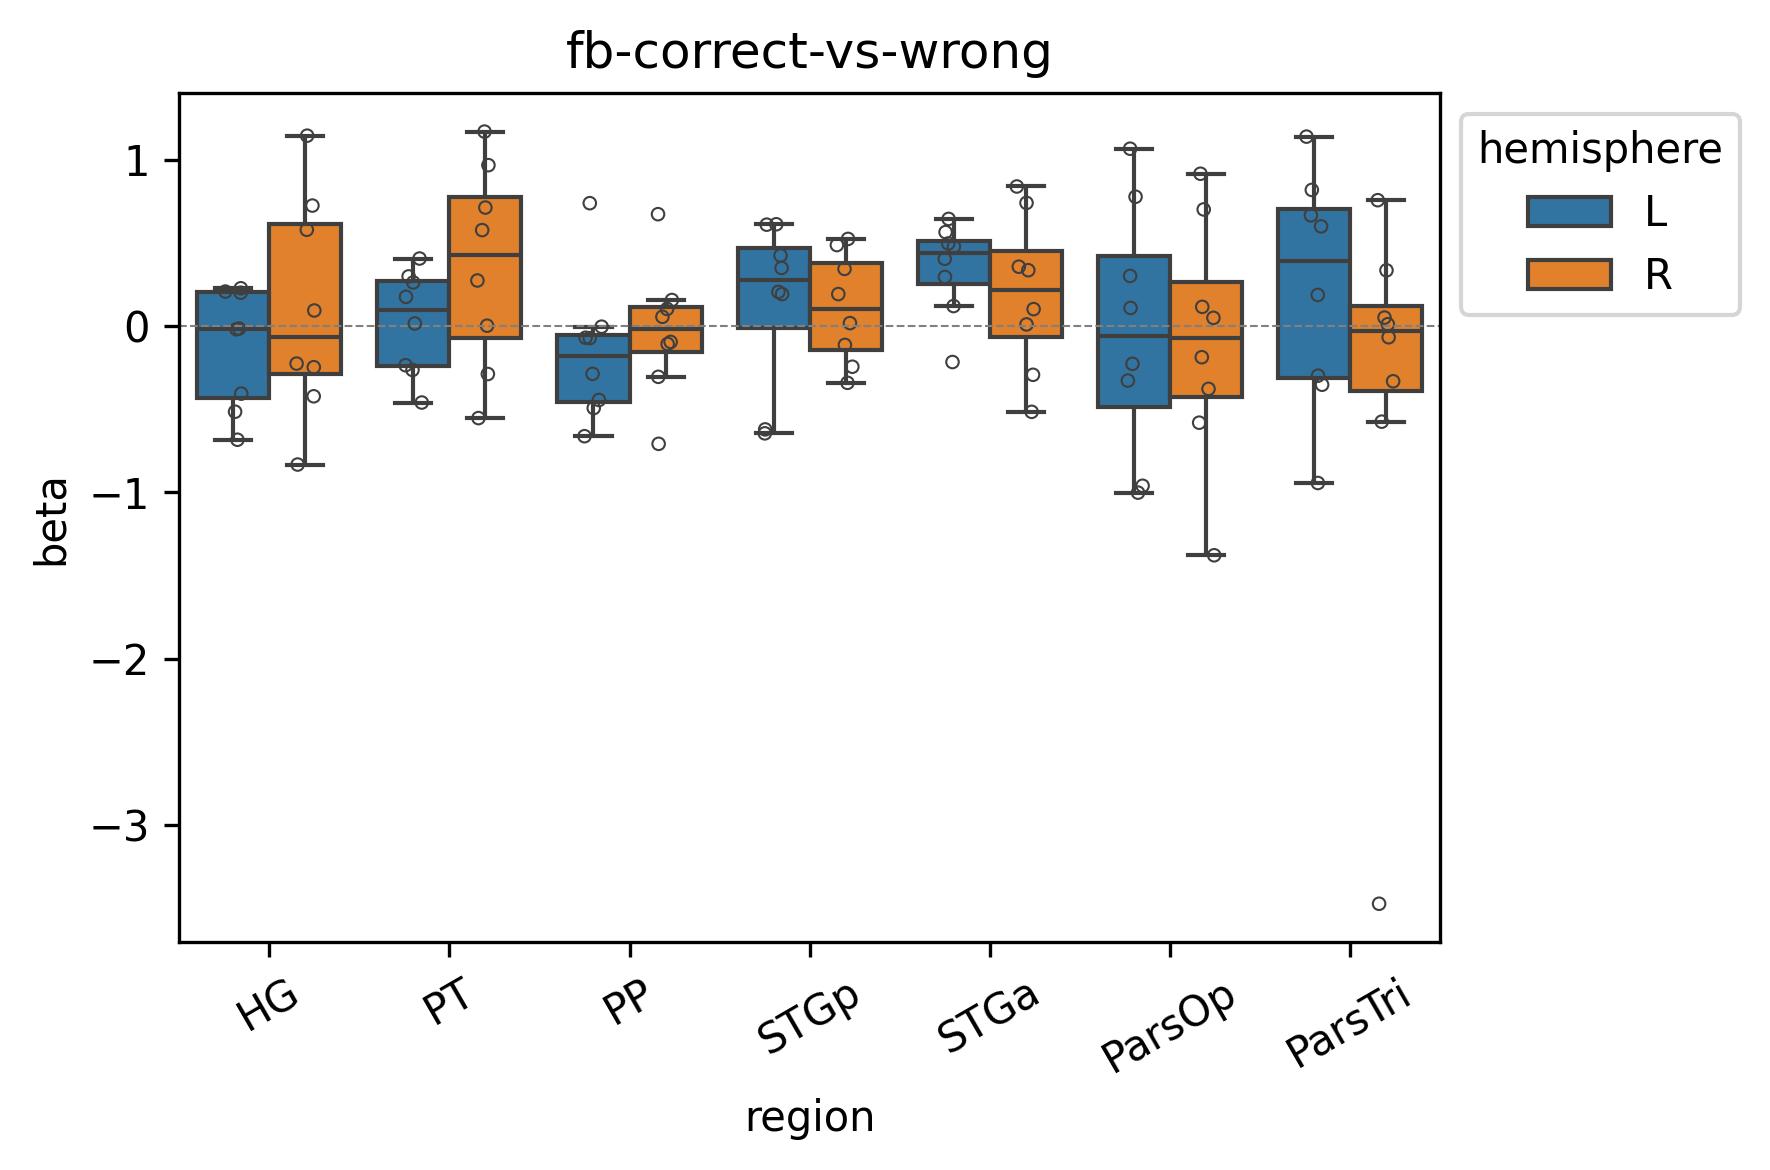

In [59]:
fig = plot_roi_box_plots(non_mandarin_df)

### Statistics

#### omnibus ANOVA stats

In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere','region', ]).fit()

# Display results
print(aov)


                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
hemisphere         0.0932 1.0000  7.0000 0.7690
region             1.0386 6.0000 42.0000 0.4143
hemisphere:region  2.0469 6.0000 42.0000 0.0804



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [62]:
# pairwise by region

# Reset the display.max_rows option to its default value
pd.reset_option('display.max_rows')

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * hemisphere,HG,L,R,-1.042210,7.0,0.331966,0.581204,0.516
1,region * hemisphere,PP,L,R,-0.775757,7.0,0.463291,0.648607,0.43
2,region * hemisphere,PT,L,R,-1.516453,7.0,0.173188,0.581204,0.781
3,region * hemisphere,ParsOp,L,R,0.227014,7.0,0.826901,0.884964,0.344
4,region * hemisphere,ParsTri,L,R,2.129699,7.0,0.070702,0.494911,1.47
5,region * hemisphere,STGa,L,R,1.041862,7.0,0.332116,0.581204,0.516
6,region * hemisphere,STGp,L,R,0.150042,7.0,0.884964,0.884964,0.339


#### Collapse (average) over non-significant factors

In [63]:
roi_df_collapsed = non_mandarin_df.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [64]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=0.635, p=0.7017


In [65]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
     HG      PP  -0.0832 0.9999 -0.8949 0.7285  False
     HG      PT    0.203 0.9869 -0.6086 1.0147  False
     HG  ParsOp  -0.0509    1.0 -0.8626 0.7608  False
     HG ParsTri  -0.0805 0.9999 -0.8922 0.7312  False
     HG    STGa   0.2845 0.9318 -0.5272 1.0961  False
     HG    STGp   0.1364 0.9985 -0.6753 0.9481  False
     PP      PT   0.2863 0.9298 -0.5254  1.098  False
     PP  ParsOp   0.0324    1.0 -0.7793 0.8441  False
     PP ParsTri   0.0028    1.0 -0.8089 0.8145  False
     PP    STGa   0.3677 0.8031  -0.444 1.1794  False
     PP    STGp   0.2196 0.9804 -0.5921 1.0313  False
     PT  ParsOp  -0.2539 0.9598 -1.0656 0.5578  False
     PT ParsTri  -0.2835 0.9328 -1.0952 0.5282  False
     PT    STGa   0.0814 0.9999 -0.7303 0.8931  False
     PT    STGp  -0.0667    1.0 -0.8784  0.745  False
 ParsOp ParsTri  -0.0296    

In [66]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0) # , df
    p_values.append(p_val)
    comparisons.append((region, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


Region: ('HG',), t-stat: -0.08 -> Corrected p=0.9363
Region: ('PP',), t-stat: -0.81 -> Corrected p=0.7799
Region: ('PT',), t-stat: 1.45 -> Corrected p=0.6360
Region: ('ParsOp',), t-stat: -0.28 -> Corrected p=0.9226
Region: ('ParsTri',), t-stat: -0.28 -> Corrected p=0.9226
Region: ('STGa',), t-stat: 2.35 -> Corrected p=0.3593
Region: ('STGp',), t-stat: 1.19 -> Corrected p=0.6360


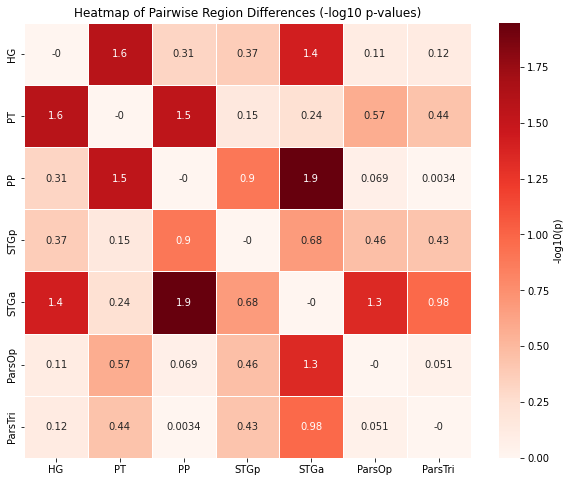

In [68]:
from itertools import combinations
from scipy.stats import ttest_rel

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


### Make 3D plots

In [106]:
region_list = region_dict[network_name]

In [107]:
mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [108]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_surface.svg')

IndexError: list index out of range

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

# `grouped_runs`: Early vs. late runs (thirds)

## `contrast-sound` for striatal network

In [57]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[0]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [58]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

masking sound stat maps for the tian_subcortical_S3 network
CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh
CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [59]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [60]:
non_mandarin_df = roi_df_long

In [ ]:
fig = plot_roi_slices(roi_mean_dict, mask_path_list, space_label)

/scratch/slurm-5327152/ipykernel_22559/102246800.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


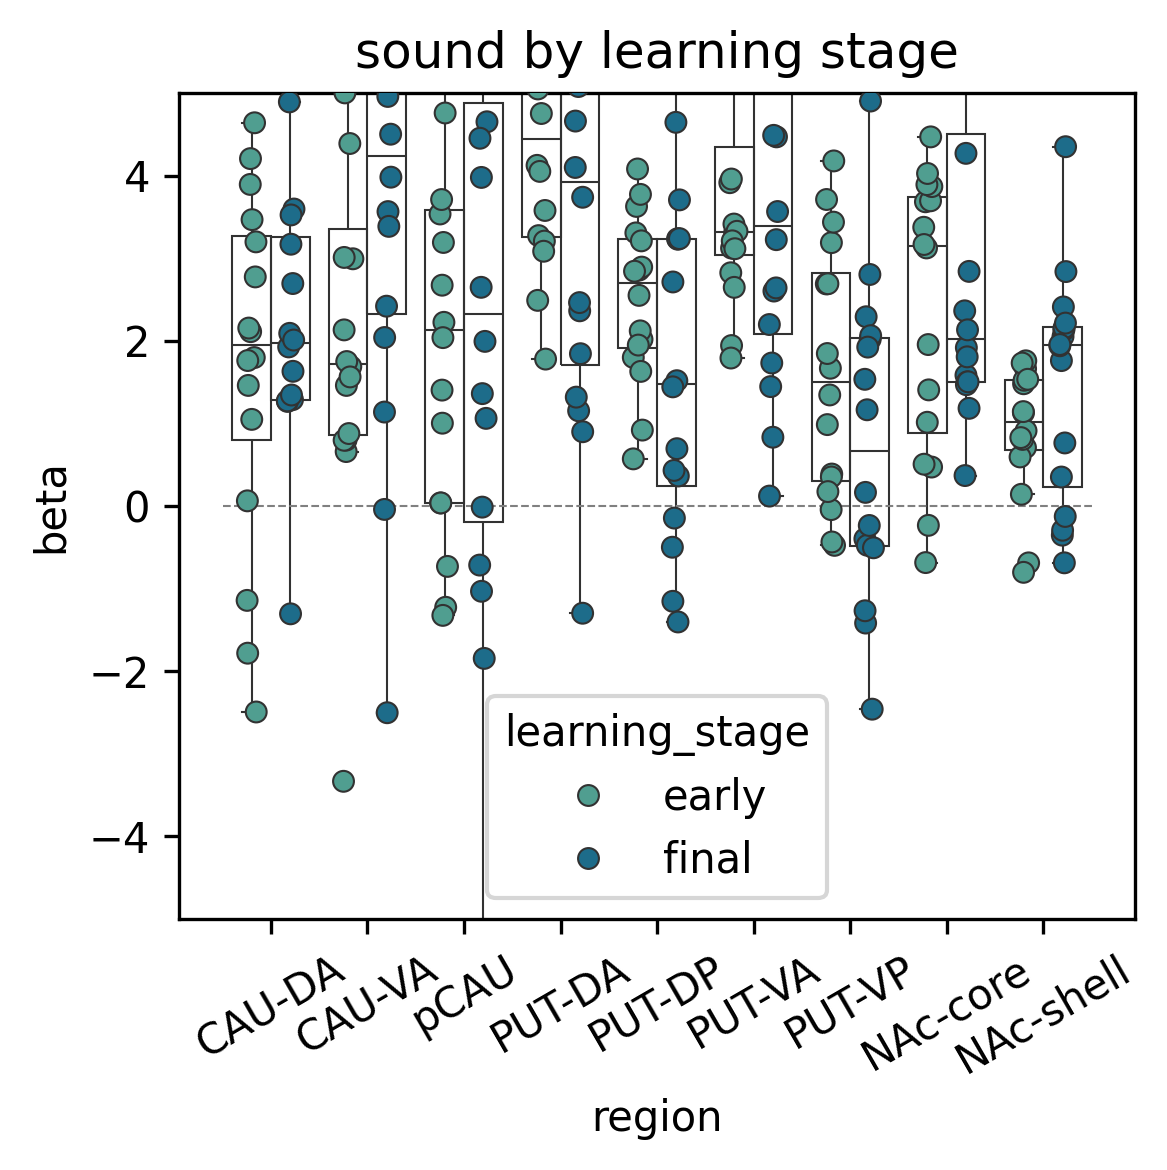

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [143]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


                            Anova
                                 F Value Num DF  Den DF Pr > F
--------------------------------------------------------------
hemisphere                        0.1367 1.0000  7.0000 0.7225
learning_stage                    0.1116 1.0000  7.0000 0.7481
region                            5.0168 8.0000 56.0000 0.0001
hemisphere:learning_stage         0.0131 1.0000  7.0000 0.9122
hemisphere:region                 1.6472 8.0000 56.0000 0.1323
learning_stage:region             2.2714 8.0000 56.0000 0.0352
hemisphere:learning_stage:region  0.8411 8.0000 56.0000 0.5708



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [144]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,learning_stage,A,B,T,dof,p-unc,p-corr,BF10
0,learning_stage * region,early,NAc-shell,PUT-DA,-7.215706,7.0,0.000175,0.006302,172.239
1,learning_stage * region,early,NAc-shell,PUT-VA,-6.259151,7.0,0.000420,0.007567,83.675
2,learning_stage * region,early,PUT-DA,PUT-DP,6.509675,7.0,0.000331,0.007567,101.811
3,learning_stage * region,early,PUT-DA,PUT-VP,7.254323,7.0,0.000169,0.006302,177.07


In [145]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * learning_stage,CAU-DA,early,final,-0.584310,7.0,0.577349,0.742306,0.388
1,region * learning_stage,CAU-VA,early,final,-1.959372,7.0,0.090904,0.713097,1.224
2,region * learning_stage,NAc-core,early,final,-0.806467,7.0,0.446503,0.727944,0.438
3,region * learning_stage,NAc-shell,early,final,-1.077622,7.0,0.316932,0.713097,0.531
4,region * learning_stage,PUT-DA,early,final,0.736631,7.0,0.485296,0.727944,0.42
5,region * learning_stage,PUT-DP,early,final,1.166740,7.0,0.281520,0.713097,0.57
6,region * learning_stage,PUT-VA,early,final,-0.235006,7.0,0.820931,0.923547,0.344
7,region * learning_stage,PUT-VP,early,final,1.256230,7.0,0.249333,0.713097,0.615
8,region * learning_stage,pCAU,early,final,0.077957,7.0,0.940044,0.940044,0.337


In [146]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,A,B,T,dof,p-unc,p-corr,BF10
0,region,CAU-DA,CAU-VA,-1.950942,7.0,0.092040,0.174391,1.214
1,region,CAU-DA,NAc-core,-1.431386,7.0,0.195413,0.298880,0.72
2,region,CAU-DA,NAc-shell,0.886921,7.0,0.404561,0.510640,0.462
3,region,CAU-DA,PUT-DA,-2.965079,7.0,0.020954,0.068985,3.674
4,region,CAU-DA,PUT-DP,-0.166391,7.0,0.872553,0.923880,0.34
5,region,CAU-DA,PUT-VA,-2.789379,7.0,0.026932,0.068985,3.03
6,region,CAU-DA,PUT-VP,0.873507,7.0,0.411349,0.510640,0.458
7,region,CAU-DA,pCAU,-0.393481,7.0,0.705674,0.793883,0.359
8,region,CAU-VA,NAc-core,0.751661,7.0,0.476762,0.572114,0.424
9,region,CAU-VA,NAc-shell,2.744193,7.0,0.028744,0.068985,2.883


/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


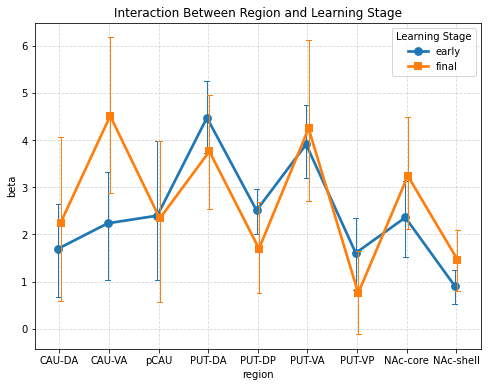

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [148]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [149]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=3.520, p=0.0020


In [150]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
   CAU-DA    CAU-VA   1.4007 0.7574 -1.2808  4.0823  False
   CAU-DA  NAc-core   0.8269 0.9855 -1.8546  3.5085  False
   CAU-DA NAc-shell  -0.7867 0.9895 -3.4682  1.8949  False
   CAU-DA    PUT-DA   2.1435 0.2213 -0.5381   4.825  False
   CAU-DA    PUT-DP   0.1316    1.0 -2.5499  2.8132  False
   CAU-DA    PUT-VA   2.1041 0.2424 -0.5775  4.7856  False
   CAU-DA    PUT-VP  -0.7903 0.9891 -3.4718  1.8913  False
   CAU-DA      pCAU   0.3958 0.9999 -2.2857  3.0774  False
   CAU-VA  NAc-core  -0.5738 0.9988 -3.2554  2.1077  False
   CAU-VA NAc-shell  -2.1874 0.1992  -4.869  0.4941  False
   CAU-VA    PUT-DA   0.7427 0.9928 -1.9388  3.4243  False
   CAU-VA    PUT-DP  -1.2691 0.8419 -3.9506  1.4125  False
   CAU-VA    PUT-VA   0.7034  0.995 -1.9782  3.3849  False
   CAU-VA    PUT-VP   -2.191 0.1975 -4.8726  0.4906  Fal

In [151]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


NameError: name 'stage' is not defined

In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-sound` for cortical network

In [ ]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[0]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [ ]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

In [ ]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [ ]:
non_mandarin_df = roi_df_long

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


In [ ]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [ ]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [ ]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-resp` for striatal network

In [ ]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[0]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [ ]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

In [ ]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [ ]:
non_mandarin_df = roi_df_long

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


In [ ]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [ ]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [ ]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-resp` for cortical network

In [ ]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[1]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [ ]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

In [ ]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [ ]:
non_mandarin_df = roi_df_long

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


In [ ]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

In [ ]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [ ]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [ ]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-fb` for striatal network

In [100]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[2]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [101]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

masking fb-correct-vs-wrong stat maps for the tian_subcortical_S3 network
CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh
CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [102]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [103]:
non_mandarin_df = roi_df_long

/scratch/slurm-5327152/ipykernel_22559/102246800.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


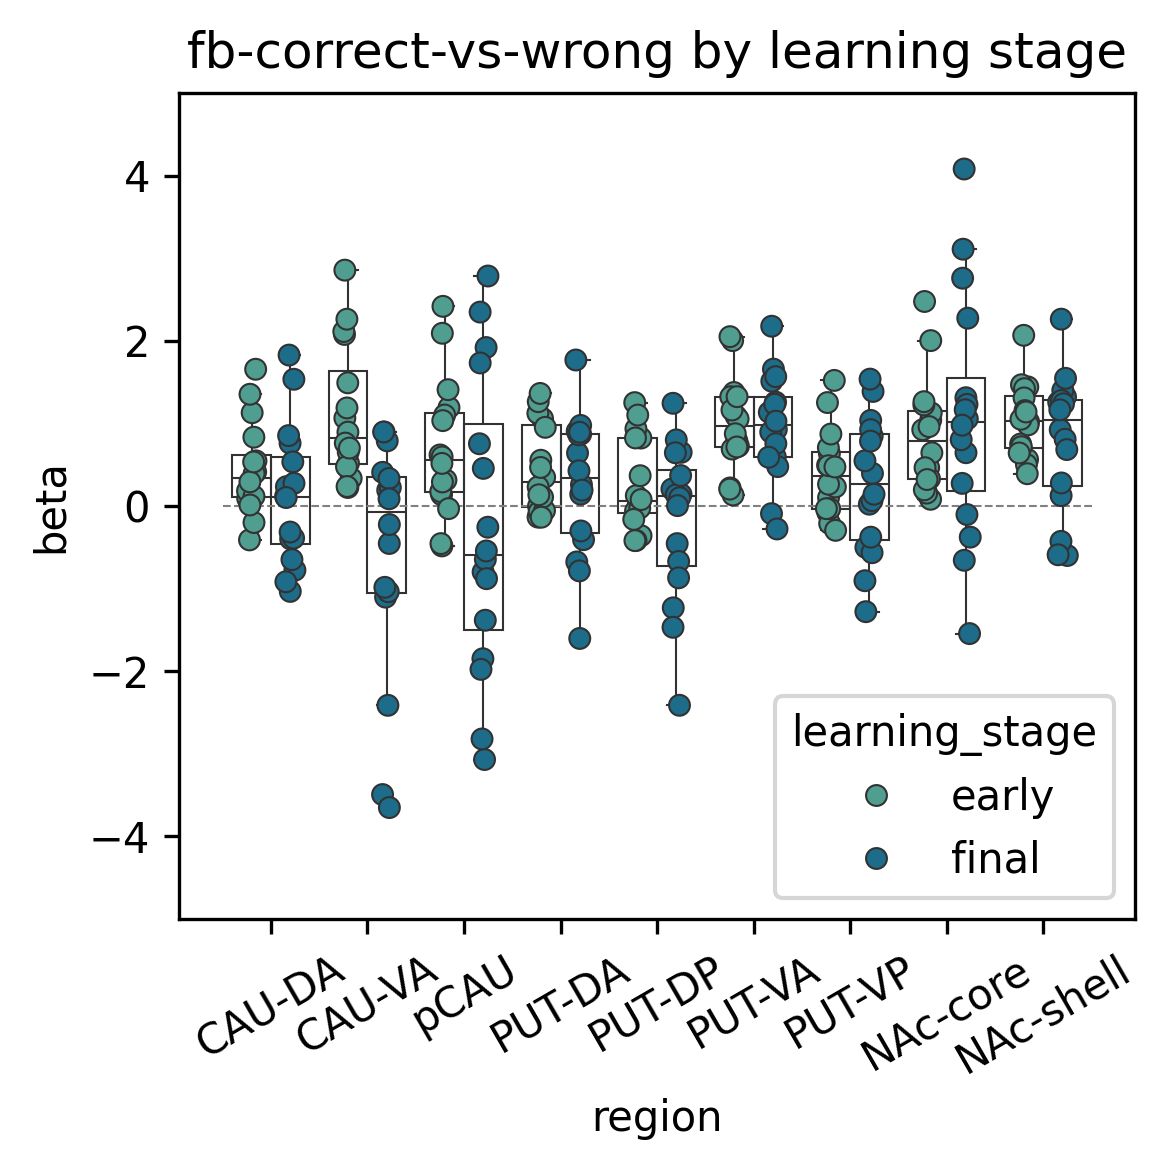

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [105]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


                            Anova
                                 F Value Num DF  Den DF Pr > F
--------------------------------------------------------------
hemisphere                        1.8441 1.0000  7.0000 0.2166
learning_stage                    7.7613 1.0000  7.0000 0.0271
region                            2.4791 8.0000 56.0000 0.0224
hemisphere:learning_stage         0.1326 1.0000  7.0000 0.7265
hemisphere:region                 1.6252 8.0000 56.0000 0.1384
learning_stage:region             2.6212 8.0000 56.0000 0.0164
hemisphere:learning_stage:region  2.0617 8.0000 56.0000 0.0553



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [106]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,learning_stage,A,B,T,dof,p-unc,p-corr,BF10
0,learning_stage * region,early,CAU-DA,CAU-VA,-4.289812,7.0,0.003612,0.047204,14.636
1,learning_stage * region,early,CAU-DA,NAc-core,-3.991729,7.0,0.005245,0.047204,10.872
2,learning_stage * region,early,CAU-VA,PUT-DP,3.894143,7.0,0.005944,0.047549,9.845
3,learning_stage * region,early,NAc-shell,PUT-DP,6.018774,7.0,0.000532,0.026948,68.969
4,learning_stage * region,early,NAc-shell,PUT-VP,4.019533,7.0,0.005063,0.047204,11.182
5,learning_stage * region,early,PUT-DA,PUT-VA,-4.188159,7.0,0.004095,0.047204,13.238
6,learning_stage * region,early,PUT-DP,PUT-VA,-5.682814,7.0,0.000749,0.026948,52.191
7,learning_stage * region,final,PUT-DA,PUT-VA,-4.853756,7.0,0.001848,0.044360,25.065
8,learning_stage * region,final,PUT-DP,PUT-VA,-4.267966,7.0,0.003710,0.047204,14.325


In [107]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * learning_stage,CAU-DA,early,final,1.428935,7.0,0.196090,0.410117,0.719
1,region * learning_stage,CAU-VA,early,final,3.984330,7.0,0.005295,0.047651,10.791
2,region * learning_stage,NAc-core,early,final,-0.433853,7.0,0.677452,0.762134,0.364
3,region * learning_stage,NAc-shell,early,final,1.321639,7.0,0.227843,0.410117,0.651
4,region * learning_stage,PUT-DA,early,final,0.525952,7.0,0.615167,0.762134,0.377
5,region * learning_stage,PUT-DP,early,final,1.341842,7.0,0.221539,0.410117,0.663
6,region * learning_stage,PUT-VA,early,final,0.057460,7.0,0.955785,0.955785,0.337
7,region * learning_stage,PUT-VP,early,final,0.549684,7.0,0.599627,0.762134,0.381
8,region * learning_stage,pCAU,early,final,1.686822,7.0,0.135498,0.410117,0.923


In [108]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,A,B,T,dof,p-unc,p-corr,BF10
0,region,CAU-DA,CAU-VA,0.077270,7.0,0.940571,0.952151,0.337
1,region,CAU-DA,NAc-core,-2.116555,7.0,0.072087,0.233499,1.449
2,region,CAU-DA,NAc-shell,-2.245650,7.0,0.059579,0.214485,1.667
3,region,CAU-DA,PUT-DA,-0.364555,7.0,0.726208,0.952151,0.356
4,region,CAU-DA,PUT-DP,0.932279,7.0,0.382222,0.655239,0.476
5,region,CAU-DA,PUT-VA,-2.979522,7.0,0.020529,0.105577,3.732
6,region,CAU-DA,PUT-VP,-0.225322,7.0,0.828166,0.952151,0.344
7,region,CAU-DA,pCAU,0.162979,7.0,0.875141,0.952151,0.34
8,region,CAU-VA,NAc-core,-1.645882,7.0,0.143784,0.295064,0.886
9,region,CAU-VA,NAc-shell,-1.666559,7.0,0.139541,0.295064,0.905


/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


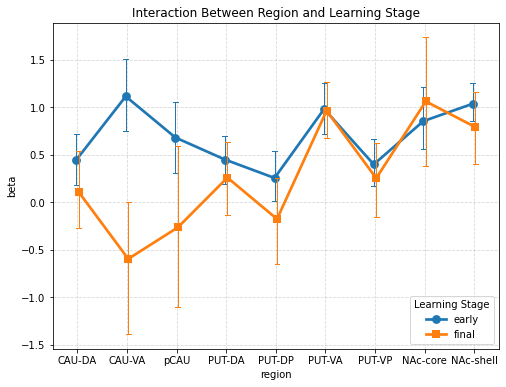

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [110]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [111]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=2.185, p=0.0404


In [112]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
   CAU-DA    CAU-VA  -0.0176    1.0  -1.135 1.0997  False
   CAU-DA  NAc-core   0.6813 0.5772 -0.4361 1.7986  False
   CAU-DA NAc-shell   0.6377 0.6604 -0.4796 1.7551  False
   CAU-DA    PUT-DA   0.0777    1.0 -1.0396 1.1951  False
   CAU-DA    PUT-DP  -0.2373 0.9989 -1.3547 0.8801  False
   CAU-DA    PUT-VA   0.6962 0.5483 -0.4212 1.8135  False
   CAU-DA    PUT-VP   0.0491    1.0 -1.0683 1.1664  False
   CAU-DA      pCAU  -0.0684    1.0 -1.1858  1.049  False
   CAU-VA  NAc-core   0.6989 0.5431 -0.4185 1.8163  False
   CAU-VA NAc-shell   0.6554 0.6269  -0.462 1.7728  False
   CAU-VA    PUT-DA   0.0954    1.0  -1.022 1.2127  False
   CAU-VA    PUT-DP  -0.2197 0.9993  -1.337 0.8977  False
   CAU-VA    PUT-VA   0.7138 0.5144 -0.4036 1.8312  False
   CAU-VA    PUT-VP   0.0667    1.0 -1.0507 1.1841  False
   CAU-VA     

In [113]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


NameError: name 'stage' is not defined

In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()


## `contrast-fb` for cortical network

In [100]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[2]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [70]:
print(f'masking {contrast_label} stat maps for the {network_name} network')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               space_label)

roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               space_label)

masking fb-correct-vs-wrong stat maps for the auditory network
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [74]:
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_latethird_df_long],)

In [95]:
non_mandarin_df = roi_df_long

/scratch/slurm-5327152/ipykernel_22559/102246800.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


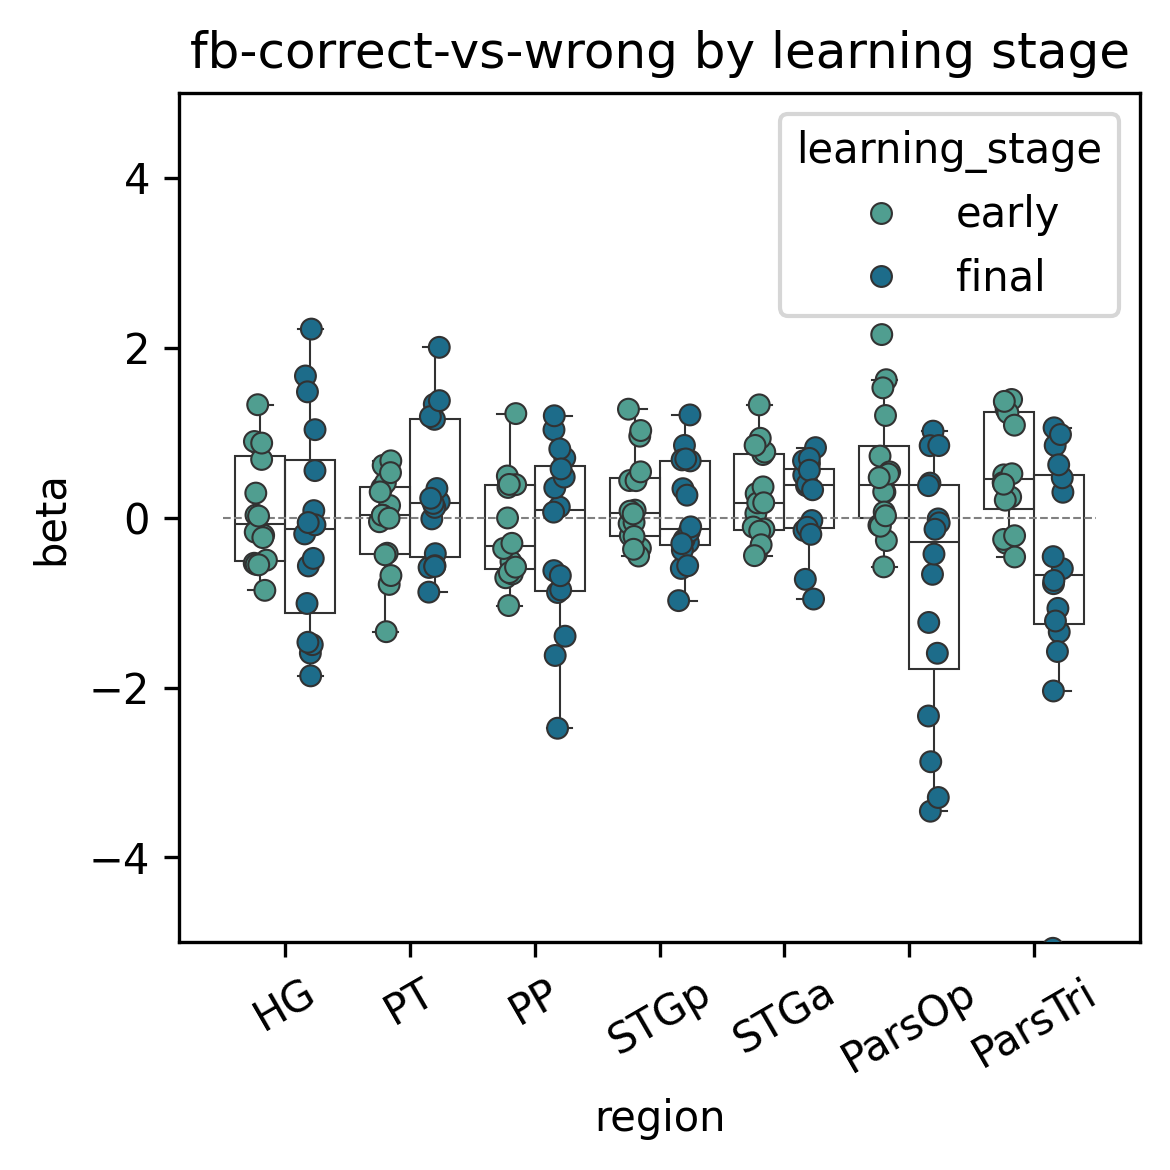

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)

sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#fdb863','#b2abd2'],
              palette='crest',
              fliersize = 0,            
              linewidth=0.5,
              legend=None,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='learning_stage',
              #palette=['#e66101','#5e3c99'],
              dodge=True,
              palette='crest',
              linewidth=0.5,
              ax=ax);


# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
#sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'{contrast_label} by learning stage');
ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              #aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print(aov)


                            Anova
                                 F Value Num DF  Den DF Pr > F
--------------------------------------------------------------
hemisphere                        0.5155 1.0000  7.0000 0.4960
learning_stage                    3.6241 1.0000  7.0000 0.0987
region                            0.8082 6.0000 42.0000 0.5694
hemisphere:learning_stage         0.2796 1.0000  7.0000 0.6133
hemisphere:region                 1.0249 6.0000 42.0000 0.4226
learning_stage:region             4.5121 6.0000 42.0000 0.0013
hemisphere:learning_stage:region  1.0001 6.0000 42.0000 0.4380



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [97]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,learning_stage,A,B,T,dof,p-unc,p-corr,BF10


In [98]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,region,A,B,T,dof,p-unc,p-corr,BF10
0,region * learning_stage,HG,early,final,0.655578,7.0,0.533042,0.813825,0.402
1,region * learning_stage,PP,early,final,0.166664,7.0,0.872346,0.872346,0.34
2,region * learning_stage,PT,early,final,-1.138282,7.0,0.292457,0.682399,0.557
3,region * learning_stage,ParsOp,early,final,2.983772,7.0,0.020406,0.075906,3.749
4,region * learning_stage,ParsTri,early,final,2.940838,7.0,0.021687,0.075906,3.577
5,region * learning_stage,STGa,early,final,0.257647,7.0,0.804090,0.872346,0.346
6,region * learning_stage,STGp,early,final,0.578108,7.0,0.581304,0.813825,0.386


In [79]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


,Contrast,A,B,T,dof,p-unc,p-corr,BF10
0,region,HG,PP,0.760795,7.0,0.471625,0.773678,0.426
1,region,HG,PT,-1.083260,7.0,0.314589,0.773678,0.533
2,region,HG,ParsOp,0.279284,7.0,0.788098,0.919448,0.348
3,region,HG,ParsTri,0.151359,7.0,0.883962,0.936732,0.34
4,region,HG,STGa,-1.111971,7.0,0.302876,0.773678,0.545
5,region,HG,STGp,-0.530489,7.0,0.612179,0.816988,0.378
6,region,PP,PT,-1.677835,7.0,0.137278,0.720708,0.915
7,region,PP,ParsOp,-0.140627,7.0,0.892126,0.936732,0.339
8,region,PP,ParsTri,-0.514917,7.0,0.622467,0.816988,0.376
9,region,PP,STGa,-3.200129,7.0,0.015063,0.316325,4.743


/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/scratch/slurm-5327152/ipykernel_22559/519582187.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


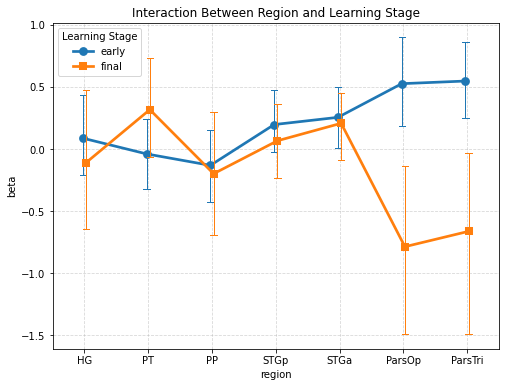

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the interaction plot
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=roi_df_long, 
    x="region", 
    y="beta", 
    hue="learning_stage", 
    dodge=True, 
    markers=["o", "s", "D"], 
    capsize=0.1, 
    errwidth=1, 
    ci=95
)

# Formatting
plt.title("Interaction Between Region and Learning Stage")
plt.legend(title="Learning Stage", loc="best")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


#### Collapse (average) over non-significant factors

In [81]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], as_index=False).agg({"beta": "mean"})


In [82]:
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(*[group["beta"].values for _, group in roi_df_collapsed.groupby("region")])

print(f"One-Way ANOVA on Region: F={f_stat:.3f}, p={p_val:.4f}")


One-Way ANOVA on Region: F=0.449, p=0.8419


In [83]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(roi_df_collapsed["beta"], roi_df_collapsed["region"])
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
     HG      PP  -0.1541 0.9989 -1.1277 0.8195  False
     HG      PT   0.1503 0.9991 -0.8233 1.1239  False
     HG  ParsOp  -0.1189 0.9998 -1.0925 0.8547  False
     HG ParsTri  -0.0463    1.0 -1.0199 0.9273  False
     HG    STGa   0.2426 0.9871  -0.731 1.2162  False
     HG    STGp    0.143 0.9993 -0.8306 1.1166  False
     PP      PT   0.3044 0.9599 -0.6692  1.278  False
     PP  ParsOp   0.0352    1.0 -0.9384 1.0088  False
     PP ParsTri   0.1078 0.9999 -0.8658 1.0814  False
     PP    STGa   0.3967 0.8696 -0.5769 1.3703  False
     PP    STGp   0.2971 0.9643 -0.6765 1.2707  False
     PT  ParsOp  -0.2692 0.9781 -1.2428 0.7044  False
     PT ParsTri  -0.1966 0.9958 -1.1702  0.777  False
     PT    STGa   0.0924 0.9999 -0.8812  1.066  False
     PT    STGp  -0.0073    1.0 -0.9809 0.9663  False
 ParsOp ParsTri   0.0726    

In [84]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region, stage, t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t-stat: {t_stat:.2f} -> Corrected p={p_val_corr:.4f}")


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
from itertools import combinations
from scipy.stats import ttest_rel

# Filter for non-Mandarin group
non_mandarin_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']

# Get unique regions
regions = non_mandarin_df['region'].unique()
region_pairs = list(combinations(regions, 2))

# Initialize matrix for p-values
pval_matrix = pd.DataFrame(index=regions, columns=regions, dtype=float)

# Pairwise t-tests for each region pair
for r1, r2 in region_pairs:
    # Subset data for each region
    data_r1 = non_mandarin_df[non_mandarin_df['region'] == r1]['beta']
    data_r2 = non_mandarin_df[non_mandarin_df['region'] == r2]['beta']
    
    # Perform paired t-test
    t_stat, p_val = ttest_rel(data_r1, data_r2, nan_policy='omit')
    
    # Populate matrix (both directions)
    pval_matrix.loc[r1, r2] = p_val
    pval_matrix.loc[r2, r1] = p_val

# Fill diagonal with 1.0 (no difference)
np.fill_diagonal(pval_matrix.values, 1.0)

# Log-transform p-values for better visualization
log_pval = -np.log10(pval_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(log_pval, annot=True, cmap='Reds', cbar_kws={'label': '-log10(p)'}, linewidths=0.5)
plt.title('Heatmap of Pairwise Region Differences (-log10 p-values)')
plt.show()
